In [286]:
import dlc_practical_prologue as prologue
import torch
from torch import  nn
from torch.nn import functional as F
import math
from torch import optim
from torch import Tensor
from torch import nn
import matplotlib.pyplot as plt
import math

In [10]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [11]:
IMAGE_SIZE = 196
NUM_CLASSES = 10

In [487]:
train_input_1 = train_input[:, 0, :, :]
train_input_2 = train_input[:, 1, :, :]
test_input_1 = test_input[:, 0, :, :]
test_input_2 = test_input[:, 1, :, :]
train_classes_1 = train_classes[:, 0]
train_classes_2 = train_classes[:, 1]
test_classes_1 = test_classes[:, 0]
test_classes_2 = test_classes[:, 1]

VALIDATION_SIZE = 500
indices = [x for x in range(0, train_input_1.size(0))][:VALIDATION_SIZE]
validation_set_input = train_input_1[indices]
validation_set_classes = train_classes_1[indices]

In [13]:
class ShallowFullyConncectedNet(nn.Module):
    def __init__(self, nb_hidden):
        super(ShallowFullyConncectedNet, self).__init__()
        self.fc1 = nn.Linear(IMAGE_SIZE, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, NUM_CLASSES)
        self.name = f"ShallowFullyConncectedNet({nb_hidden})"

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, IMAGE_SIZE)))
        x = self.fc2(x)
        return x

In [14]:
class DeepFullyConncectedNet(nn.Module):
    def __init__(self, nb_layers):
        super(DeepFullyConncectedNet, self).__init__()
        self.layers = nn.ModuleList([])
        self.name = f"DeepFullyConncectedNet({nb_layers})"
        acc = IMAGE_SIZE
        if nb_layers % 2 !=0:
            nb_layers = nb_layers - 1
        for l in range(nb_layers):
            if l < nb_layers/2:
                self.layers.append(nn.Linear(acc, acc*2))
                acc = acc*2
            else:
                self.layers.append(nn.Linear(acc, int(acc/2)))
                acc = int(acc/2)
        self.layers.append(nn.Linear(IMAGE_SIZE, 10))

        

    def forward(self, x):
        acc = IMAGE_SIZE
        for l in range(len(self.layers)-1):
            x = F.relu(self.layers[l](x.view(-1, acc)))
            if l < (len(self.layers)-1)/2:
                acc = acc*2
            else:
                acc = int(acc/2)
        x = self.layers[len(self.layers)-1](x)

       
        return x

In [408]:
class BasicCNN(nn.Module):
    def __init__(self, nb_hidden):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.name = f"BasicCNN({nb_hidden})"

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x.view(-1, 1, 14, 14)), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [445]:
class BasicCNN_bis(nn.Module):
    def __init__(self, dropout = 0):
        super(BasicCNN_bis, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=4)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=4)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4)
        self.fc1 = nn.Linear(32*5*5, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 
        self.drop = nn.Dropout(dropout)
        self.name = f"BasicCNN_bis(dropout = {dropout})"

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 1, 14, 14)))
        x = self.drop(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = F.relu(self.fc1(x.view(-1, 32*5*5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [609]:
class BasicCNN_bn(nn.Module):
    def __init__(self, dropout = 0):
        super(BasicCNN_bn, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=4)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 32, kernel_size=4)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 
        self.drop = nn.Dropout(dropout)
        self.name = f"BasicCNN with batch normalization, dropout = {dropout}"

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x.view(-1, 1, 14, 14))))
        x = self.drop(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.drop(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.drop(x)
        print('x ', x.size())
        x = F.relu(self.fc1(x.view(-1, 64*5*5)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        print('x ', x.size)
        return x

In [618]:
def double_conv(in_channels, out_channels, dropout):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.BatchNorm2d(out_channels)
    )   


class UNet(nn.Module):

    def __init__(self, dropout = 0):
        super(UNet, self).__init__()
                
        self.conv_down1 = double_conv(1, 64, dropout)
        self.conv_down2 = double_conv(64, 128, dropout)
        self.conv_down3 = double_conv(128, 256, dropout)
        #self.conv_down4 = double_conv(256, 512, dropout)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        #self.dconv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128, dropout)
        self.conv_up1 = double_conv(128, 64, dropout)
        
        #self.conv_last = nn.Conv2d(64, 10, 1)
        self.fc1 = nn.Linear(64*6*6, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.name = f"UNet"
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x.view(-1, 1, 14, 14))
        x = self.maxpool(conv1)

        conv2 = self.conv_down2(x)
        #x = self.maxpool(conv2)
        
        #conv3 = self.conv_down3(x)
        #x = self.maxpool(conv3)   
        
        #x = self.conv_down4(x)
        
        #x = self.upsample(x)        
        #x = torch.cat([x, conv3], dim=1)
        
        #x = self.conv_up3(x)
        #x = self.upsample(x)        
        #x = torch.cat([x, conv2], dim=1)       

        #x = self.conv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.conv_up1(x)
        #print('x ', x.size())
        #x = self.conv_last(x)
        
        #x = F.relu(self.fc1(x.view(-1, 10*6*6)))
        #x = self.fc2(x)
        x = F.relu(self.fc1(x.view(-1, 64*6*6)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
# TODO 
# class ResNetBlock(nn.Module):
#     def __init__(self, nb_channels, kernel_size,
#                  skip_connections = True, batch_normalization = True):
#         super(ResNetBlock, self).__init__()

#         self.conv1 = nn.Conv2d(nb_channels, nb_channels,
#                                kernel_size = kernel_size,
#                                padding = (kernel_size - 1) // 2)

#         self.bn1 = nn.BatchNorm2d(nb_channels)

#         self.conv2 = nn.Conv2d(nb_channels, nb_channels,
#                                kernel_size = kernel_size,
#                                padding = (kernel_size - 1) // 2)

#         self.bn2 = nn.BatchNorm2d(nb_channels)

#         self.skip_connections = skip_connections
#         self.batch_normalization = batch_normalization
        

#     def forward(self, x):
#         y = self.conv1(x)
#         if self.batch_normalization: y = self.bn1(y)
#         y = F.relu(y)
#         y = self.conv2(y)
#         if self.batch_normalization: y = self.bn2(y)
#         if self.skip_connections: y = y + x
#         y = F.relu(y)

#         return y
    

# class ResNet(nn.Module):

#     def __init__(self, nb_residual_blocks, nb_channels,
#                  kernel_size = 3, nb_classes = 10,
#                  skip_connections = True, batch_normalization = True):
#         super(ResNet, self).__init__()

#         self.conv = nn.Conv2d(3, nb_channels,
#                               kernel_size = kernel_size,
#                               padding = (kernel_size - 1) // 2)
#         self.bn = nn.BatchNorm2d(nb_channels)

#         self.resnet_blocks = nn.Sequential(
#             *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
#               for _ in range(nb_residual_blocks))
#         )

#         self.fc = nn.Linear(nb_channels, nb_classes)

#     def forward(self, x):
#         x = F.relu(self.bn(self.conv(x)))
#         x = self.resnet_blocks(x)
#         x = F.avg_pool2d(x, 32).view(x.size(0), -1)
#         x = self.fc(x)
#         return x


In [520]:
optimizer_methods = {
    'SGD': (lambda parameters, eta, momentum: optim.SGD(parameters(), eta, momentum = momentum)),
    'Adam': (lambda parameters, eta, momentum: optim.Adam(parameters(), eta))
}

In [521]:
def train_model(model, train_input, train_target, mini_batch_size, eta, criterion = nn.CrossEntropyLoss(), 
                nb_epochs = 25, validation_set_input = None, validation_set_target = None, 
                momentum = 0, optimizer_name = 'SGD'):
    accuracy = []
    accuracy_test = []
    optimizer = optimizer_methods[optimizer_name](model.parameters, eta, momentum)
    for e in range(nb_epochs):
        running_accuracy = 0
        running_accuracy_test = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_accuracy += compute_nb_correct_digit(output, b, train_target, mini_batch_size)
            
        running_loss = loss.item()
        with torch.no_grad():
            output = model(validation_set_input)
            loss = criterion(output, validation_set_target)

            running_loss_test = loss.item()
            running_accuracy_test += compute_nb_correct_digit(output, 0, validation_set_target, VALIDATION_SIZE)
            
        # print loss statistics
        print('[epoch %d] train loss: %.3f, test loss: %.3f' % (e + 1, running_loss, running_loss_test))
              
        # compute accuracy
        accuracy.append(running_accuracy / train_input.size(0))
        accuracy_test.append(running_accuracy_test / VALIDATION_SIZE)
    return accuracy, accuracy_test

In [513]:
def compute_nb_correct_digit(output, b, target, mini_batch_size):
    nb_corrects = 0
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        if target[b + k] == predicted_classes[k]:
            nb_corrects += 1
    return nb_corrects 

In [514]:
def compute_percentage_project_error(model, input1, input2, target, mini_batch_size):
    nb_errors = 0
    for b in range(0, input1.size(0), mini_batch_size):
        output1 = model(input1.narrow(0, b, mini_batch_size))
        output2 = model(input2.narrow(0, b, mini_batch_size))
        _, predicted_classes1 = output1.max(1)
        _, predicted_classes2 = output2.max(1)
        for k in range(mini_batch_size):
            if target[b + k] != (predicted_classes1[k] <= predicted_classes2[k]):
                nb_errors = nb_errors + 1

    return nb_errors / target.size(0) * 100

In [515]:
def plot_accuracy(accuracy, epochs, accuracy_test):
    x = [epoch for epoch in range(1, epochs + 1)]
    plt.plot(x, accuracy, color='green', label = 'train accuracy')
    plt.plot(x, accuracy_test, color = 'orange', label = 'test accuracy')
    plt.xlabel('Number of epoch')
    plt.ylabel('Digit acuuracy')
    plt.title('Accuracy in function of the number of epochs')
    plt.legend()
    plt.show()

In [516]:
def train_test(model, mini_batch_size, eta, criterion, nb_epochs, momentum = 0, optimizer_name = 'SGD'):
    train = torch.cat((train_input_1, train_input_2), 0)
    target = torch.cat((train_classes_1, train_classes_2), 0)

    accuracy, accuracy_test = train_model(model, train, target, mini_batch_size, eta, criterion, nb_epochs, 
                                          validation_set_input, validation_set_classes, momentum, optimizer_name)
    plot_accuracy(accuracy, nb_epochs, accuracy_test)
    train_error = compute_percentage_project_error(model, train_input_1, train_input_2, train_target, mini_batch_size) 
    test_error = compute_percentage_project_error(model, test_input_1, test_input_2, test_target, mini_batch_size) 
    print(f'MODEL: {model.name}, BATCH_SIZE: { mini_batch_size}, CRITERION: {str(criterion)}, EPOCHS: {nb_epochs}, train_error:{train_error}%, test_error: {test_error}%')

### Basic CNN optimization:

#### Momentum = 0

[epoch 1] train loss: 2.038, test loss: 2.119
[epoch 2] train loss: 1.823, test loss: 1.486
[epoch 3] train loss: 0.951, test loss: 0.956
[epoch 4] train loss: 1.921, test loss: 1.137
[epoch 5] train loss: 0.756, test loss: 0.577
[epoch 6] train loss: 0.439, test loss: 0.428
[epoch 7] train loss: 0.419, test loss: 0.378
[epoch 8] train loss: 0.680, test loss: 0.556
[epoch 9] train loss: 0.339, test loss: 0.299
[epoch 10] train loss: 0.149, test loss: 0.124
[epoch 11] train loss: 0.085, test loss: 0.090
[epoch 12] train loss: 0.082, test loss: 0.036
[epoch 13] train loss: 0.076, test loss: 0.070
[epoch 14] train loss: 0.025, test loss: 0.032
[epoch 15] train loss: 0.042, test loss: 0.042
[epoch 16] train loss: 0.393, test loss: 0.861
[epoch 17] train loss: 0.250, test loss: 0.245
[epoch 18] train loss: 0.024, test loss: 0.062
[epoch 19] train loss: 0.004, test loss: 0.022
[epoch 20] train loss: 0.003, test loss: 0.005
[epoch 21] train loss: 0.003, test loss: 0.005
[epoch 22] train loss:

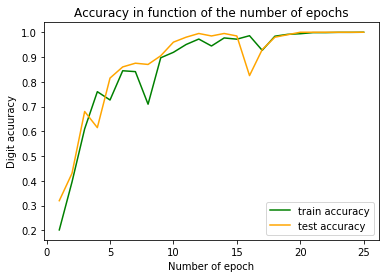

MODEL: BasicCNN_bis, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:0.0%, test_error: 3.9%


In [429]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

[epoch 1] train loss: 2.090, test loss: 2.263
[epoch 2] train loss: 2.175, test loss: 2.140
[epoch 3] train loss: 2.145, test loss: 1.946
[epoch 4] train loss: 1.981, test loss: 2.140
[epoch 5] train loss: 1.567, test loss: 1.144
[epoch 6] train loss: 1.707, test loss: 1.415
[epoch 7] train loss: 1.316, test loss: 1.559
[epoch 8] train loss: 0.573, test loss: 0.634
[epoch 9] train loss: 0.432, test loss: 0.313
[epoch 10] train loss: 0.530, test loss: 0.661
[epoch 11] train loss: 0.256, test loss: 0.325
[epoch 12] train loss: 0.199, test loss: 0.152
[epoch 13] train loss: 0.158, test loss: 0.117
[epoch 14] train loss: 0.112, test loss: 0.075
[epoch 15] train loss: 0.109, test loss: 0.072
[epoch 16] train loss: 0.474, test loss: 0.473
[epoch 17] train loss: 0.092, test loss: 0.055
[epoch 18] train loss: 0.046, test loss: 0.146
[epoch 19] train loss: 0.029, test loss: 0.034
[epoch 20] train loss: 0.007, test loss: 0.019
[epoch 21] train loss: 0.004, test loss: 0.011
[epoch 22] train loss:

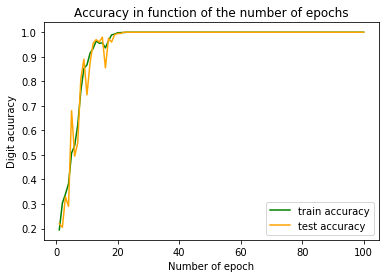

MODEL: BasicCNN_bis, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.0%, test_error: 5.0%


In [438]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100)

[epoch 1] train loss: 2.284, test loss: 2.301
[epoch 2] train loss: 2.216, test loss: 2.186
[epoch 3] train loss: 2.061, test loss: 2.022
[epoch 4] train loss: 1.547, test loss: 1.648
[epoch 5] train loss: 1.465, test loss: 1.240
[epoch 6] train loss: 1.570, test loss: 1.474
[epoch 7] train loss: 0.864, test loss: 0.859
[epoch 8] train loss: 0.932, test loss: 0.853
[epoch 9] train loss: 0.558, test loss: 0.596
[epoch 10] train loss: 0.765, test loss: 0.720
[epoch 11] train loss: 0.576, test loss: 0.353
[epoch 12] train loss: 0.338, test loss: 0.347
[epoch 13] train loss: 0.273, test loss: 0.280
[epoch 14] train loss: 0.166, test loss: 0.209
[epoch 15] train loss: 0.272, test loss: 0.219
[epoch 16] train loss: 0.261, test loss: 0.161
[epoch 17] train loss: 0.175, test loss: 0.142
[epoch 18] train loss: 0.206, test loss: 0.149
[epoch 19] train loss: 0.154, test loss: 0.118
[epoch 20] train loss: 0.099, test loss: 0.144
[epoch 21] train loss: 0.112, test loss: 0.091
[epoch 22] train loss:

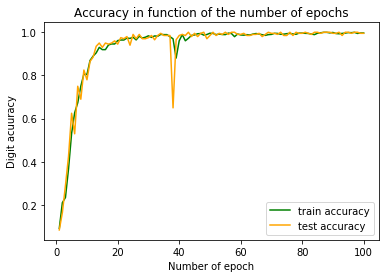

MODEL: BasicCNN_bis, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.3%, test_error: 4.2%


In [442]:
train_test(BasicCNN_bis(dropout = 0.1), 100, eta = 1e-1, criterion = nn.CrossEntropyLoss(), nb_epochs = 100)

[epoch 1] train loss: 1.916, test loss: 1.772
[epoch 2] train loss: 0.763, test loss: 0.706
[epoch 3] train loss: 0.447, test loss: 0.416
[epoch 4] train loss: 0.301, test loss: 0.263
[epoch 5] train loss: 0.216, test loss: 0.180
[epoch 6] train loss: 0.154, test loss: 0.130
[epoch 7] train loss: 0.112, test loss: 0.090
[epoch 8] train loss: 0.072, test loss: 0.062
[epoch 9] train loss: 0.054, test loss: 0.046
[epoch 10] train loss: 0.041, test loss: 0.033
[epoch 11] train loss: 0.031, test loss: 0.025
[epoch 12] train loss: 0.024, test loss: 0.019
[epoch 13] train loss: 0.020, test loss: 0.016
[epoch 14] train loss: 0.017, test loss: 0.014
[epoch 15] train loss: 0.015, test loss: 0.013
[epoch 16] train loss: 0.013, test loss: 0.011
[epoch 17] train loss: 0.011, test loss: 0.010
[epoch 18] train loss: 0.009, test loss: 0.009
[epoch 19] train loss: 0.008, test loss: 0.008
[epoch 20] train loss: 0.007, test loss: 0.007
[epoch 21] train loss: 0.006, test loss: 0.006
[epoch 22] train loss:

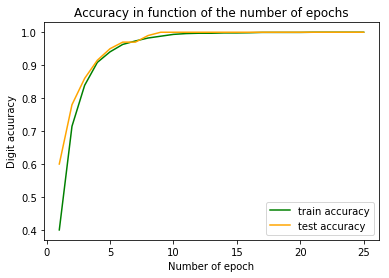

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:0.0%, test_error: 2.7%


In [463]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25)

[epoch 1] train loss: 1.578, test loss: 1.482
[epoch 2] train loss: 0.691, test loss: 0.706
[epoch 3] train loss: 0.426, test loss: 0.437
[epoch 4] train loss: 0.273, test loss: 0.282
[epoch 5] train loss: 0.194, test loss: 0.200
[epoch 6] train loss: 0.137, test loss: 0.142
[epoch 7] train loss: 0.103, test loss: 0.101
[epoch 8] train loss: 0.079, test loss: 0.074
[epoch 9] train loss: 0.063, test loss: 0.055
[epoch 10] train loss: 0.047, test loss: 0.041
[epoch 11] train loss: 0.034, test loss: 0.031
[epoch 12] train loss: 0.028, test loss: 0.025
[epoch 13] train loss: 0.024, test loss: 0.022
[epoch 14] train loss: 0.020, test loss: 0.019
[epoch 15] train loss: 0.017, test loss: 0.017
[epoch 16] train loss: 0.014, test loss: 0.015
[epoch 17] train loss: 0.012, test loss: 0.013
[epoch 18] train loss: 0.010, test loss: 0.011
[epoch 19] train loss: 0.009, test loss: 0.010
[epoch 20] train loss: 0.008, test loss: 0.008
[epoch 21] train loss: 0.007, test loss: 0.007
[epoch 22] train loss:

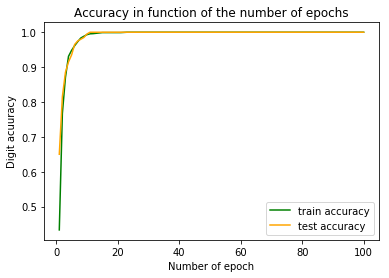

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.0%, test_error: 3.2%


In [464]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100)

[epoch 1] train loss: 2.042, test loss: 1.976
[epoch 2] train loss: 1.189, test loss: 1.109
[epoch 3] train loss: 0.676, test loss: 0.687
[epoch 4] train loss: 0.517, test loss: 0.442
[epoch 5] train loss: 0.377, test loss: 0.360
[epoch 6] train loss: 0.237, test loss: 0.302
[epoch 7] train loss: 0.258, test loss: 0.284
[epoch 8] train loss: 0.278, test loss: 0.235
[epoch 9] train loss: 0.248, test loss: 0.307
[epoch 10] train loss: 0.244, test loss: 0.197
[epoch 11] train loss: 0.210, test loss: 0.153
[epoch 12] train loss: 0.150, test loss: 0.144
[epoch 13] train loss: 0.134, test loss: 0.101
[epoch 14] train loss: 0.155, test loss: 0.141
[epoch 15] train loss: 0.127, test loss: 0.100
[epoch 16] train loss: 0.123, test loss: 0.111
[epoch 17] train loss: 0.140, test loss: 0.156
[epoch 18] train loss: 0.101, test loss: 0.094
[epoch 19] train loss: 0.094, test loss: 0.122
[epoch 20] train loss: 0.094, test loss: 0.068
[epoch 21] train loss: 0.122, test loss: 0.069
[epoch 22] train loss:

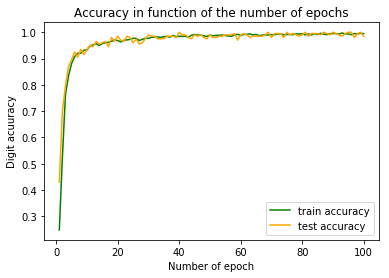

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.4%, test_error: 3.0%


In [465]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100)

[epoch 1] train loss: 2.291, test loss: 2.275
[epoch 2] train loss: 2.216, test loss: 2.176
[epoch 3] train loss: 1.823, test loss: 1.703
[epoch 4] train loss: 1.398, test loss: 1.194
[epoch 5] train loss: 1.120, test loss: 0.993
[epoch 6] train loss: 0.857, test loss: 0.840
[epoch 7] train loss: 0.878, test loss: 0.751
[epoch 8] train loss: 0.749, test loss: 0.676
[epoch 9] train loss: 0.616, test loss: 0.616
[epoch 10] train loss: 0.575, test loss: 0.487
[epoch 11] train loss: 0.575, test loss: 0.488
[epoch 12] train loss: 0.596, test loss: 0.468
[epoch 13] train loss: 0.476, test loss: 0.493
[epoch 14] train loss: 0.418, test loss: 0.470
[epoch 15] train loss: 0.543, test loss: 0.465
[epoch 16] train loss: 0.404, test loss: 0.407
[epoch 17] train loss: 0.400, test loss: 0.371
[epoch 18] train loss: 0.420, test loss: 0.319
[epoch 19] train loss: 0.422, test loss: 0.332
[epoch 20] train loss: 0.463, test loss: 0.346
[epoch 21] train loss: 0.408, test loss: 0.341
[epoch 22] train loss:

[epoch 174] train loss: 0.058, test loss: 0.046
[epoch 175] train loss: 0.075, test loss: 0.075
[epoch 176] train loss: 0.057, test loss: 0.098
[epoch 177] train loss: 0.120, test loss: 0.061
[epoch 178] train loss: 0.179, test loss: 0.082
[epoch 179] train loss: 0.039, test loss: 0.051
[epoch 180] train loss: 0.155, test loss: 0.082
[epoch 181] train loss: 0.086, test loss: 0.038
[epoch 182] train loss: 0.061, test loss: 0.115
[epoch 183] train loss: 0.072, test loss: 0.048
[epoch 184] train loss: 0.029, test loss: 0.115
[epoch 185] train loss: 0.070, test loss: 0.050
[epoch 186] train loss: 0.102, test loss: 0.099
[epoch 187] train loss: 0.134, test loss: 0.127
[epoch 188] train loss: 0.075, test loss: 0.081
[epoch 189] train loss: 0.066, test loss: 0.088
[epoch 190] train loss: 0.129, test loss: 0.035
[epoch 191] train loss: 0.092, test loss: 0.040
[epoch 192] train loss: 0.050, test loss: 0.053
[epoch 193] train loss: 0.147, test loss: 0.026
[epoch 194] train loss: 0.070, test loss

[epoch 345] train loss: 0.104, test loss: 0.043
[epoch 346] train loss: 0.028, test loss: 0.048
[epoch 347] train loss: 0.022, test loss: 0.063
[epoch 348] train loss: 0.087, test loss: 0.040
[epoch 349] train loss: 0.026, test loss: 0.028
[epoch 350] train loss: 0.103, test loss: 0.027
[epoch 351] train loss: 0.046, test loss: 0.043
[epoch 352] train loss: 0.008, test loss: 0.034
[epoch 353] train loss: 0.078, test loss: 0.024
[epoch 354] train loss: 0.022, test loss: 0.032
[epoch 355] train loss: 0.037, test loss: 0.023
[epoch 356] train loss: 0.056, test loss: 0.064
[epoch 357] train loss: 0.074, test loss: 0.080
[epoch 358] train loss: 0.020, test loss: 0.016
[epoch 359] train loss: 0.056, test loss: 0.103
[epoch 360] train loss: 0.040, test loss: 0.079
[epoch 361] train loss: 0.080, test loss: 0.051
[epoch 362] train loss: 0.044, test loss: 0.052
[epoch 363] train loss: 0.024, test loss: 0.026
[epoch 364] train loss: 0.045, test loss: 0.024
[epoch 365] train loss: 0.092, test loss

[epoch 516] train loss: 0.013, test loss: 0.016
[epoch 517] train loss: 0.062, test loss: 0.025
[epoch 518] train loss: 0.040, test loss: 0.076
[epoch 519] train loss: 0.076, test loss: 0.029
[epoch 520] train loss: 0.037, test loss: 0.047
[epoch 521] train loss: 0.049, test loss: 0.018
[epoch 522] train loss: 0.049, test loss: 0.042
[epoch 523] train loss: 0.032, test loss: 0.019
[epoch 524] train loss: 0.023, test loss: 0.022
[epoch 525] train loss: 0.049, test loss: 0.047
[epoch 526] train loss: 0.033, test loss: 0.060
[epoch 527] train loss: 0.014, test loss: 0.076
[epoch 528] train loss: 0.038, test loss: 0.051
[epoch 529] train loss: 0.005, test loss: 0.010
[epoch 530] train loss: 0.028, test loss: 0.023
[epoch 531] train loss: 0.140, test loss: 0.031
[epoch 532] train loss: 0.072, test loss: 0.050
[epoch 533] train loss: 0.033, test loss: 0.046
[epoch 534] train loss: 0.052, test loss: 0.027
[epoch 535] train loss: 0.036, test loss: 0.022
[epoch 536] train loss: 0.029, test loss

[epoch 687] train loss: 0.007, test loss: 0.014
[epoch 688] train loss: 0.029, test loss: 0.028
[epoch 689] train loss: 0.065, test loss: 0.041
[epoch 690] train loss: 0.029, test loss: 0.013
[epoch 691] train loss: 0.008, test loss: 0.043
[epoch 692] train loss: 0.030, test loss: 0.012
[epoch 693] train loss: 0.026, test loss: 0.017
[epoch 694] train loss: 0.004, test loss: 0.057
[epoch 695] train loss: 0.071, test loss: 0.022
[epoch 696] train loss: 0.020, test loss: 0.015
[epoch 697] train loss: 0.038, test loss: 0.008
[epoch 698] train loss: 0.018, test loss: 0.042
[epoch 699] train loss: 0.021, test loss: 0.052
[epoch 700] train loss: 0.050, test loss: 0.013
[epoch 701] train loss: 0.012, test loss: 0.017
[epoch 702] train loss: 0.021, test loss: 0.024
[epoch 703] train loss: 0.068, test loss: 0.033
[epoch 704] train loss: 0.008, test loss: 0.027
[epoch 705] train loss: 0.017, test loss: 0.011
[epoch 706] train loss: 0.037, test loss: 0.045
[epoch 707] train loss: 0.011, test loss

[epoch 858] train loss: 0.028, test loss: 0.028
[epoch 859] train loss: 0.016, test loss: 0.023
[epoch 860] train loss: 0.004, test loss: 0.035
[epoch 861] train loss: 0.015, test loss: 0.015
[epoch 862] train loss: 0.032, test loss: 0.030
[epoch 863] train loss: 0.005, test loss: 0.015
[epoch 864] train loss: 0.033, test loss: 0.016
[epoch 865] train loss: 0.039, test loss: 0.021
[epoch 866] train loss: 0.011, test loss: 0.030
[epoch 867] train loss: 0.006, test loss: 0.004
[epoch 868] train loss: 0.062, test loss: 0.034
[epoch 869] train loss: 0.024, test loss: 0.016
[epoch 870] train loss: 0.005, test loss: 0.026
[epoch 871] train loss: 0.014, test loss: 0.003
[epoch 872] train loss: 0.014, test loss: 0.010
[epoch 873] train loss: 0.024, test loss: 0.039
[epoch 874] train loss: 0.022, test loss: 0.010
[epoch 875] train loss: 0.007, test loss: 0.019
[epoch 876] train loss: 0.070, test loss: 0.059
[epoch 877] train loss: 0.022, test loss: 0.009
[epoch 878] train loss: 0.023, test loss

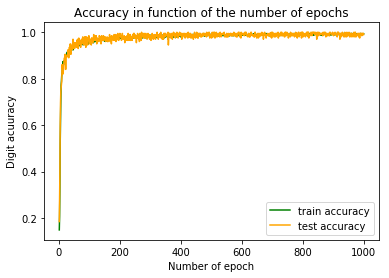

MODEL: BasicCNN with batch normalization, dropout = 0.5, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 1000, train_error:0.5%, test_error: 3.6999999999999997%


In [472]:
train_test(BasicCNN_bn(dropout = 0.5), 100, eta = 0.1, criterion =nn.CrossEntropyLoss(), nb_epochs = 1000)

#### Monentum = 0.9

[epoch 1] train loss: 2.306, test loss: 2.294
[epoch 2] train loss: 2.300, test loss: 2.297
[epoch 3] train loss: 2.263, test loss: 2.248
[epoch 4] train loss: 2.001, test loss: 1.926
[epoch 5] train loss: 1.788, test loss: 1.633
[epoch 6] train loss: 1.797, test loss: 1.560
[epoch 7] train loss: 1.624, test loss: 1.542
[epoch 8] train loss: 1.647, test loss: 1.498
[epoch 9] train loss: 1.571, test loss: 1.315
[epoch 10] train loss: 1.441, test loss: 1.232
[epoch 11] train loss: 1.360, test loss: 1.214
[epoch 12] train loss: 1.329, test loss: 1.156
[epoch 13] train loss: 1.417, test loss: 1.090
[epoch 14] train loss: 1.321, test loss: 1.124
[epoch 15] train loss: 1.240, test loss: 1.132
[epoch 16] train loss: 1.156, test loss: 1.018
[epoch 17] train loss: 1.133, test loss: 0.934
[epoch 18] train loss: 1.054, test loss: 0.877
[epoch 19] train loss: 1.099, test loss: 0.837
[epoch 20] train loss: 1.083, test loss: 0.802
[epoch 21] train loss: 0.911, test loss: 0.838
[epoch 22] train loss:

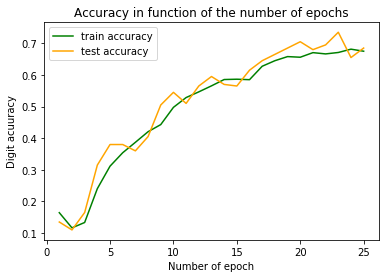

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:20.200000000000003%, test_error: 22.900000000000002%


In [479]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: nan, test loss: nan
[epoch 2] train loss: nan, test loss: nan
[epoch 3] train loss: nan, test loss: nan
[epoch 4] train loss: nan, test loss: nan
[epoch 5] train loss: nan, test loss: nan
[epoch 6] train loss: nan, test loss: nan
[epoch 7] train loss: nan, test loss: nan
[epoch 8] train loss: nan, test loss: nan
[epoch 9] train loss: nan, test loss: nan
[epoch 10] train loss: nan, test loss: nan
[epoch 11] train loss: nan, test loss: nan
[epoch 12] train loss: nan, test loss: nan
[epoch 13] train loss: nan, test loss: nan
[epoch 14] train loss: nan, test loss: nan
[epoch 15] train loss: nan, test loss: nan
[epoch 16] train loss: nan, test loss: nan
[epoch 17] train loss: nan, test loss: nan
[epoch 18] train loss: nan, test loss: nan
[epoch 19] train loss: nan, test loss: nan
[epoch 20] train loss: nan, test loss: nan
[epoch 21] train loss: nan, test loss: nan
[epoch 22] train loss: nan, test loss: nan
[epoch 23] train loss: nan, test loss: nan
[epoch 24] train los

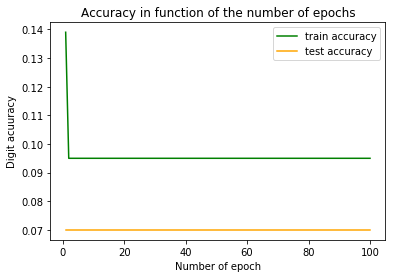

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:45.2%, test_error: 47.599999999999994%


In [480]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.322, test loss: 2.441
[epoch 2] train loss: 2.167, test loss: 2.064
[epoch 3] train loss: 1.964, test loss: 2.176
[epoch 4] train loss: 1.944, test loss: 2.006
[epoch 5] train loss: 1.875, test loss: 1.891
[epoch 6] train loss: 1.729, test loss: 1.732
[epoch 7] train loss: 1.780, test loss: 1.856
[epoch 8] train loss: 1.845, test loss: 1.672
[epoch 9] train loss: 1.619, test loss: 1.591
[epoch 10] train loss: 1.699, test loss: 1.594
[epoch 11] train loss: 1.639, test loss: 1.251
[epoch 12] train loss: 1.387, test loss: 1.239
[epoch 13] train loss: 1.382, test loss: 1.305
[epoch 14] train loss: 1.224, test loss: 1.134
[epoch 15] train loss: 1.206, test loss: 0.996
[epoch 16] train loss: 1.168, test loss: 0.985
[epoch 17] train loss: 1.207, test loss: 1.158
[epoch 18] train loss: 1.239, test loss: 1.031
[epoch 19] train loss: 1.299, test loss: 1.075
[epoch 20] train loss: 1.202, test loss: 0.961
[epoch 21] train loss: 1.170, test loss: 0.908
[epoch 22] train loss:

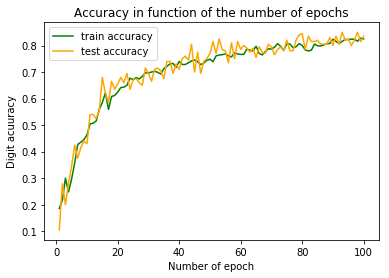

MODEL: BasicCNN_bis(dropout = 0.1), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:12.5%, test_error: 21.9%


In [481]:
train_test(BasicCNN_bis(dropout = 0.1), 100, eta = 1e-1, criterion = nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 1.029, test loss: 0.752
[epoch 2] train loss: 0.276, test loss: 0.299
[epoch 3] train loss: 0.250, test loss: 0.153
[epoch 4] train loss: 0.132, test loss: 0.115
[epoch 5] train loss: 0.104, test loss: 0.092
[epoch 6] train loss: 0.088, test loss: 0.084
[epoch 7] train loss: 0.131, test loss: 0.178
[epoch 8] train loss: 0.127, test loss: 0.136
[epoch 9] train loss: 0.194, test loss: 0.077
[epoch 10] train loss: 0.082, test loss: 0.044
[epoch 11] train loss: 0.080, test loss: 0.037
[epoch 12] train loss: 0.008, test loss: 0.005
[epoch 13] train loss: 0.010, test loss: 0.018
[epoch 14] train loss: 0.032, test loss: 0.003
[epoch 15] train loss: 0.007, test loss: 0.009
[epoch 16] train loss: 0.007, test loss: 0.001
[epoch 17] train loss: 0.007, test loss: 0.002
[epoch 18] train loss: 0.001, test loss: 0.002
[epoch 19] train loss: 0.001, test loss: 0.000
[epoch 20] train loss: 0.001, test loss: 0.001
[epoch 21] train loss: 0.000, test loss: 0.001
[epoch 22] train loss:

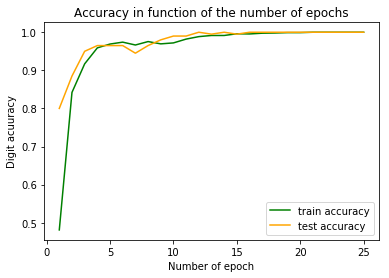

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:0.0%, test_error: 2.3%


In [482]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 1.050, test loss: 0.791
[epoch 2] train loss: 0.302, test loss: 0.248
[epoch 3] train loss: 0.230, test loss: 0.136
[epoch 4] train loss: 0.200, test loss: 0.149
[epoch 5] train loss: 0.181, test loss: 0.214
[epoch 6] train loss: 0.148, test loss: 0.118
[epoch 7] train loss: 0.100, test loss: 0.129
[epoch 8] train loss: 0.038, test loss: 0.053
[epoch 9] train loss: 0.102, test loss: 0.107
[epoch 10] train loss: 0.148, test loss: 0.177
[epoch 11] train loss: 0.034, test loss: 0.065
[epoch 12] train loss: 0.007, test loss: 0.026
[epoch 13] train loss: 0.019, test loss: 0.026
[epoch 14] train loss: 0.001, test loss: 0.013
[epoch 15] train loss: 0.007, test loss: 0.003
[epoch 16] train loss: 0.001, test loss: 0.005
[epoch 17] train loss: 0.001, test loss: 0.001
[epoch 18] train loss: 0.001, test loss: 0.001
[epoch 19] train loss: 0.002, test loss: 0.000
[epoch 20] train loss: 0.001, test loss: 0.000
[epoch 21] train loss: 0.001, test loss: 0.000
[epoch 22] train loss:

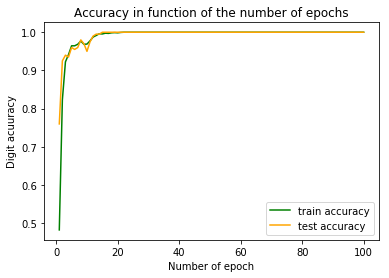

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.0%, test_error: 2.0%


In [483]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 1.043, test loss: 0.833
[epoch 2] train loss: 0.567, test loss: 0.654
[epoch 3] train loss: 0.368, test loss: 0.332
[epoch 4] train loss: 0.369, test loss: 0.320
[epoch 5] train loss: 0.264, test loss: 0.214
[epoch 6] train loss: 0.180, test loss: 0.240
[epoch 7] train loss: 0.184, test loss: 0.199
[epoch 8] train loss: 0.197, test loss: 0.167
[epoch 9] train loss: 0.174, test loss: 0.131
[epoch 10] train loss: 0.130, test loss: 0.122
[epoch 11] train loss: 0.113, test loss: 0.127
[epoch 12] train loss: 0.245, test loss: 0.171
[epoch 13] train loss: 0.151, test loss: 0.164
[epoch 14] train loss: 0.067, test loss: 0.128
[epoch 15] train loss: 0.171, test loss: 0.233
[epoch 16] train loss: 0.128, test loss: 0.227
[epoch 17] train loss: 0.140, test loss: 0.160
[epoch 18] train loss: 0.101, test loss: 0.089
[epoch 19] train loss: 0.062, test loss: 0.049
[epoch 20] train loss: 0.078, test loss: 0.052
[epoch 21] train loss: 0.045, test loss: 0.036
[epoch 22] train loss:

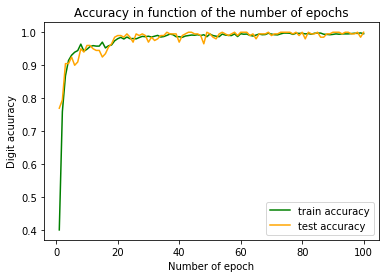

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.1%, test_error: 2.3%


In [484]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.058, test loss: 1.430
[epoch 2] train loss: 0.526, test loss: 0.540
[epoch 3] train loss: 0.342, test loss: 0.297
[epoch 4] train loss: 0.363, test loss: 0.261
[epoch 5] train loss: 0.383, test loss: 0.203
[epoch 6] train loss: 0.293, test loss: 0.145
[epoch 7] train loss: 0.206, test loss: 0.209
[epoch 8] train loss: 0.305, test loss: 0.152
[epoch 9] train loss: 0.237, test loss: 0.176
[epoch 10] train loss: 0.148, test loss: 0.178
[epoch 11] train loss: 0.258, test loss: 0.183
[epoch 12] train loss: 0.123, test loss: 0.196
[epoch 13] train loss: 0.074, test loss: 0.095
[epoch 14] train loss: 0.091, test loss: 0.060
[epoch 15] train loss: 0.098, test loss: 0.054
[epoch 16] train loss: 0.058, test loss: 0.066
[epoch 17] train loss: 0.010, test loss: 0.061
[epoch 18] train loss: 0.021, test loss: 0.035
[epoch 19] train loss: 0.022, test loss: 0.025
[epoch 20] train loss: 0.052, test loss: 0.025
[epoch 21] train loss: 0.066, test loss: 0.040
[epoch 22] train loss:

[epoch 174] train loss: 0.002, test loss: 0.003
[epoch 175] train loss: 0.005, test loss: 0.000
[epoch 176] train loss: 0.001, test loss: 0.000
[epoch 177] train loss: 0.000, test loss: 0.001
[epoch 178] train loss: 0.000, test loss: 0.001
[epoch 179] train loss: 0.001, test loss: 0.003
[epoch 180] train loss: 0.000, test loss: 0.000
[epoch 181] train loss: 0.001, test loss: 0.002
[epoch 182] train loss: 0.000, test loss: 0.004
[epoch 183] train loss: 0.002, test loss: 0.000
[epoch 184] train loss: 0.000, test loss: 0.001
[epoch 185] train loss: 0.000, test loss: 0.000
[epoch 186] train loss: 0.000, test loss: 0.000
[epoch 187] train loss: 0.000, test loss: 0.001
[epoch 188] train loss: 0.000, test loss: 0.000
[epoch 189] train loss: 0.000, test loss: 0.001
[epoch 190] train loss: 0.036, test loss: 0.003
[epoch 191] train loss: 0.000, test loss: 0.006
[epoch 192] train loss: 0.001, test loss: 0.002
[epoch 193] train loss: 0.006, test loss: 0.004
[epoch 194] train loss: 0.001, test loss

[epoch 345] train loss: 0.000, test loss: 0.001
[epoch 346] train loss: 0.000, test loss: 0.000
[epoch 347] train loss: 0.001, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.001
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.000, test loss: 0.003
[epoch 353] train loss: 0.000, test loss: 0.007
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.000, test loss: 0.000
[epoch 356] train loss: 0.000, test loss: 0.000
[epoch 357] train loss: 0.000, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.000
[epoch 359] train loss: 0.000, test loss: 0.004
[epoch 360] train loss: 0.000, test loss: 0.001
[epoch 361] train loss: 0.000, test loss: 0.002
[epoch 362] train loss: 0.000, test loss: 0.011
[epoch 363] train loss: 0.011, test loss: 0.000
[epoch 364] train loss: 0.000, test loss: 0.000
[epoch 365] train loss: 0.000, test loss

[epoch 516] train loss: 0.000, test loss: 0.001
[epoch 517] train loss: 0.000, test loss: 0.000
[epoch 518] train loss: 0.000, test loss: 0.000
[epoch 519] train loss: 0.001, test loss: 0.000
[epoch 520] train loss: 0.000, test loss: 0.000
[epoch 521] train loss: 0.000, test loss: 0.000
[epoch 522] train loss: 0.000, test loss: 0.000
[epoch 523] train loss: 0.000, test loss: 0.005
[epoch 524] train loss: 0.000, test loss: 0.000
[epoch 525] train loss: 0.000, test loss: 0.000
[epoch 526] train loss: 0.000, test loss: 0.000
[epoch 527] train loss: 0.000, test loss: 0.000
[epoch 528] train loss: 0.002, test loss: 0.000
[epoch 529] train loss: 0.009, test loss: 0.001
[epoch 530] train loss: 0.000, test loss: 0.000
[epoch 531] train loss: 0.000, test loss: 0.000
[epoch 532] train loss: 0.000, test loss: 0.004
[epoch 533] train loss: 0.001, test loss: 0.001
[epoch 534] train loss: 0.001, test loss: 0.000
[epoch 535] train loss: 0.000, test loss: 0.000
[epoch 536] train loss: 0.000, test loss

[epoch 687] train loss: 0.000, test loss: 0.000
[epoch 688] train loss: 0.001, test loss: 0.002
[epoch 689] train loss: 0.000, test loss: 0.000
[epoch 690] train loss: 0.000, test loss: 0.000
[epoch 691] train loss: 0.000, test loss: 0.000
[epoch 692] train loss: 0.000, test loss: 0.000
[epoch 693] train loss: 0.000, test loss: 0.000
[epoch 694] train loss: 0.000, test loss: 0.000
[epoch 695] train loss: 0.000, test loss: 0.000
[epoch 696] train loss: 0.000, test loss: 0.000
[epoch 697] train loss: 0.000, test loss: 0.000
[epoch 698] train loss: 0.000, test loss: 0.000
[epoch 699] train loss: 0.000, test loss: 0.000
[epoch 700] train loss: 0.000, test loss: 0.000
[epoch 701] train loss: 0.000, test loss: 0.000
[epoch 702] train loss: 0.000, test loss: 0.000
[epoch 703] train loss: 0.002, test loss: 0.000
[epoch 704] train loss: 0.000, test loss: 0.000
[epoch 705] train loss: 0.000, test loss: 0.000
[epoch 706] train loss: 0.002, test loss: 0.000
[epoch 707] train loss: 0.000, test loss

[epoch 858] train loss: 0.000, test loss: 0.001
[epoch 859] train loss: 0.000, test loss: 0.000
[epoch 860] train loss: 0.006, test loss: 0.001
[epoch 861] train loss: 0.000, test loss: 0.000
[epoch 862] train loss: 0.000, test loss: 0.000
[epoch 863] train loss: 0.000, test loss: 0.000
[epoch 864] train loss: 0.000, test loss: 0.000
[epoch 865] train loss: 0.001, test loss: 0.001
[epoch 866] train loss: 0.000, test loss: 0.000
[epoch 867] train loss: 0.000, test loss: 0.004
[epoch 868] train loss: 0.000, test loss: 0.000
[epoch 869] train loss: 0.000, test loss: 0.000
[epoch 870] train loss: 0.000, test loss: 0.000
[epoch 871] train loss: 0.000, test loss: 0.000
[epoch 872] train loss: 0.000, test loss: 0.002
[epoch 873] train loss: 0.000, test loss: 0.000
[epoch 874] train loss: 0.000, test loss: 0.000
[epoch 875] train loss: 0.000, test loss: 0.000
[epoch 876] train loss: 0.000, test loss: 0.000
[epoch 877] train loss: 0.000, test loss: 0.000
[epoch 878] train loss: 0.000, test loss

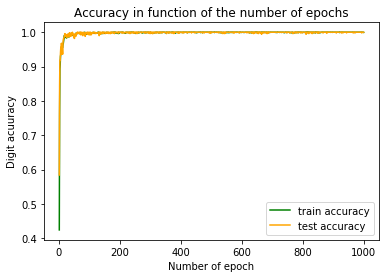

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 1000, train_error:0.0%, test_error: 1.7000000000000002%


In [493]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 1000, momentum = 0.9)

[epoch 1] train loss: 0.978, test loss: 0.805
[epoch 2] train loss: 0.345, test loss: 0.463
[epoch 3] train loss: 0.294, test loss: 0.129
[epoch 4] train loss: 0.275, test loss: 0.158
[epoch 5] train loss: 0.178, test loss: 0.125
[epoch 6] train loss: 0.103, test loss: 0.137
[epoch 7] train loss: 0.050, test loss: 0.130
[epoch 8] train loss: 0.060, test loss: 0.168
[epoch 9] train loss: 0.042, test loss: 0.207
[epoch 10] train loss: 0.096, test loss: 0.076
[epoch 11] train loss: 0.082, test loss: 0.021
[epoch 12] train loss: 0.010, test loss: 0.022
[epoch 13] train loss: 0.017, test loss: 0.024
[epoch 14] train loss: 0.011, test loss: 0.011
[epoch 15] train loss: 0.004, test loss: 0.014
[epoch 16] train loss: 0.008, test loss: 0.014
[epoch 17] train loss: 0.005, test loss: 0.004
[epoch 18] train loss: 0.001, test loss: 0.002
[epoch 19] train loss: 0.000, test loss: 0.001
[epoch 20] train loss: 0.000, test loss: 0.001
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

[epoch 174] train loss: 0.000, test loss: 0.000
[epoch 175] train loss: 0.000, test loss: 0.000
[epoch 176] train loss: 0.000, test loss: 0.000
[epoch 177] train loss: 0.000, test loss: 0.000
[epoch 178] train loss: 0.000, test loss: 0.000
[epoch 179] train loss: 0.000, test loss: 0.000
[epoch 180] train loss: 0.000, test loss: 0.000
[epoch 181] train loss: 0.000, test loss: 0.000
[epoch 182] train loss: 0.000, test loss: 0.000
[epoch 183] train loss: 0.000, test loss: 0.000
[epoch 184] train loss: 0.000, test loss: 0.000
[epoch 185] train loss: 0.000, test loss: 0.000
[epoch 186] train loss: 0.000, test loss: 0.000
[epoch 187] train loss: 0.000, test loss: 0.000
[epoch 188] train loss: 0.000, test loss: 0.000
[epoch 189] train loss: 0.000, test loss: 0.000
[epoch 190] train loss: 0.000, test loss: 0.000
[epoch 191] train loss: 0.000, test loss: 0.000
[epoch 192] train loss: 0.000, test loss: 0.000
[epoch 193] train loss: 0.000, test loss: 0.000
[epoch 194] train loss: 0.000, test loss

[epoch 345] train loss: 0.000, test loss: 0.000
[epoch 346] train loss: 0.000, test loss: 0.000
[epoch 347] train loss: 0.000, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.000
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.000, test loss: 0.000
[epoch 353] train loss: 0.000, test loss: 0.000
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.000, test loss: 0.000
[epoch 356] train loss: 0.000, test loss: 0.000
[epoch 357] train loss: 0.000, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.000
[epoch 359] train loss: 0.000, test loss: 0.000
[epoch 360] train loss: 0.000, test loss: 0.000
[epoch 361] train loss: 0.000, test loss: 0.000
[epoch 362] train loss: 0.000, test loss: 0.000
[epoch 363] train loss: 0.000, test loss: 0.000
[epoch 364] train loss: 0.000, test loss: 0.000
[epoch 365] train loss: 0.000, test loss

[epoch 516] train loss: 0.000, test loss: 0.000
[epoch 517] train loss: 0.000, test loss: 0.000
[epoch 518] train loss: 0.000, test loss: 0.000
[epoch 519] train loss: 0.000, test loss: 0.000
[epoch 520] train loss: 0.000, test loss: 0.000
[epoch 521] train loss: 0.000, test loss: 0.000
[epoch 522] train loss: 0.000, test loss: 0.000
[epoch 523] train loss: 0.000, test loss: 0.000
[epoch 524] train loss: 0.000, test loss: 0.000
[epoch 525] train loss: 0.000, test loss: 0.000
[epoch 526] train loss: 0.000, test loss: 0.000
[epoch 527] train loss: 0.000, test loss: 0.000
[epoch 528] train loss: 0.000, test loss: 0.000
[epoch 529] train loss: 0.000, test loss: 0.000
[epoch 530] train loss: 0.000, test loss: 0.000
[epoch 531] train loss: 0.000, test loss: 0.000
[epoch 532] train loss: 0.000, test loss: 0.000
[epoch 533] train loss: 0.000, test loss: 0.000
[epoch 534] train loss: 0.000, test loss: 0.000
[epoch 535] train loss: 0.000, test loss: 0.000
[epoch 536] train loss: 0.000, test loss

[epoch 687] train loss: 0.000, test loss: 0.000
[epoch 688] train loss: 0.000, test loss: 0.000
[epoch 689] train loss: 0.000, test loss: 0.000
[epoch 690] train loss: 0.000, test loss: 0.000
[epoch 691] train loss: 0.000, test loss: 0.000
[epoch 692] train loss: 0.000, test loss: 0.000
[epoch 693] train loss: 0.000, test loss: 0.000
[epoch 694] train loss: 0.000, test loss: 0.000
[epoch 695] train loss: 0.000, test loss: 0.000
[epoch 696] train loss: 0.000, test loss: 0.000
[epoch 697] train loss: 0.000, test loss: 0.000
[epoch 698] train loss: 0.000, test loss: 0.000
[epoch 699] train loss: 0.000, test loss: 0.000
[epoch 700] train loss: 0.000, test loss: 0.000
[epoch 701] train loss: 0.000, test loss: 0.000
[epoch 702] train loss: 0.000, test loss: 0.000
[epoch 703] train loss: 0.000, test loss: 0.000
[epoch 704] train loss: 0.000, test loss: 0.000
[epoch 705] train loss: 0.000, test loss: 0.000
[epoch 706] train loss: 0.000, test loss: 0.000
[epoch 707] train loss: 0.000, test loss

[epoch 858] train loss: 0.000, test loss: 0.000
[epoch 859] train loss: 0.000, test loss: 0.000
[epoch 860] train loss: 0.000, test loss: 0.000
[epoch 861] train loss: 0.000, test loss: 0.000
[epoch 862] train loss: 0.000, test loss: 0.000
[epoch 863] train loss: 0.000, test loss: 0.000
[epoch 864] train loss: 0.000, test loss: 0.000
[epoch 865] train loss: 0.000, test loss: 0.000
[epoch 866] train loss: 0.000, test loss: 0.000
[epoch 867] train loss: 0.000, test loss: 0.000
[epoch 868] train loss: 0.000, test loss: 0.000
[epoch 869] train loss: 0.000, test loss: 0.000
[epoch 870] train loss: 0.000, test loss: 0.000
[epoch 871] train loss: 0.000, test loss: 0.000
[epoch 872] train loss: 0.000, test loss: 0.000
[epoch 873] train loss: 0.000, test loss: 0.000
[epoch 874] train loss: 0.000, test loss: 0.000
[epoch 875] train loss: 0.000, test loss: 0.000
[epoch 876] train loss: 0.000, test loss: 0.000
[epoch 877] train loss: 0.000, test loss: 0.000
[epoch 878] train loss: 0.000, test loss

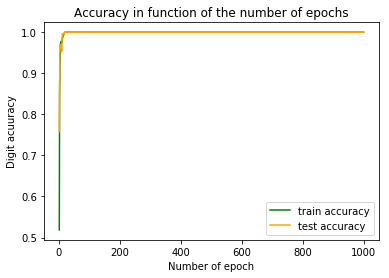

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 1000, train_error:0.0%, test_error: 2.5%


In [494]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 1000, momentum = 0.9)

#### Adam optimizer

[epoch 1] train loss: 2.373, test loss: 2.225
[epoch 2] train loss: 2.218, test loss: 2.222
[epoch 3] train loss: 1.840, test loss: 1.965
[epoch 4] train loss: 2.011, test loss: 1.681
[epoch 5] train loss: 1.446, test loss: 1.287
[epoch 6] train loss: 1.545, test loss: 1.095
[epoch 7] train loss: 1.069, test loss: 0.948
[epoch 8] train loss: 1.092, test loss: 0.797
[epoch 9] train loss: 1.102, test loss: 0.719
[epoch 10] train loss: 0.844, test loss: 0.663
[epoch 11] train loss: 0.982, test loss: 0.644
[epoch 12] train loss: 0.679, test loss: 0.625
[epoch 13] train loss: 0.902, test loss: 0.729
[epoch 14] train loss: 0.685, test loss: 0.547
[epoch 15] train loss: 0.661, test loss: 0.773
[epoch 16] train loss: 0.698, test loss: 0.939
[epoch 17] train loss: 0.562, test loss: 0.582
[epoch 18] train loss: 0.426, test loss: 0.529
[epoch 19] train loss: 0.622, test loss: 0.518
[epoch 20] train loss: 0.591, test loss: 0.443
[epoch 21] train loss: 0.523, test loss: 0.447
[epoch 22] train loss:

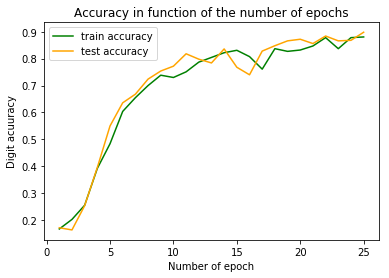

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:7.6%, test_error: 10.299999999999999%


In [502]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, optimizer_name = 'Adam')

[epoch 1] train loss: 2.137, test loss: 2.205
[epoch 2] train loss: 2.049, test loss: 2.083
[epoch 3] train loss: 2.154, test loss: 1.905
[epoch 4] train loss: 1.694, test loss: 1.688
[epoch 5] train loss: 1.497, test loss: 1.377
[epoch 6] train loss: 1.288, test loss: 1.170
[epoch 7] train loss: 1.396, test loss: 1.208
[epoch 8] train loss: 1.023, test loss: 0.981
[epoch 9] train loss: 0.939, test loss: 0.929
[epoch 10] train loss: 0.839, test loss: 0.766
[epoch 11] train loss: 0.757, test loss: 0.616
[epoch 12] train loss: 0.657, test loss: 0.611
[epoch 13] train loss: 0.664, test loss: 0.585
[epoch 14] train loss: 0.608, test loss: 0.530
[epoch 15] train loss: 0.572, test loss: 0.608
[epoch 16] train loss: 0.599, test loss: 0.511
[epoch 17] train loss: 0.454, test loss: 0.383
[epoch 18] train loss: 0.471, test loss: 0.477
[epoch 19] train loss: 0.584, test loss: 0.493
[epoch 20] train loss: 0.495, test loss: 0.470
[epoch 21] train loss: 0.486, test loss: 0.379
[epoch 22] train loss:

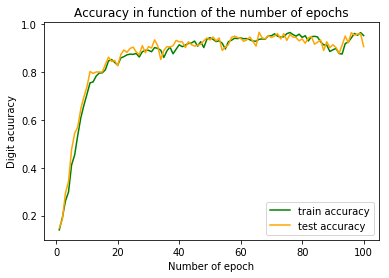

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:5.5%, test_error: 10.8%


In [503]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, optimizer_name = 'Adam')

[epoch 1] train loss: 2.320, test loss: 2.336
[epoch 2] train loss: 2.331, test loss: 2.308
[epoch 3] train loss: 2.242, test loss: 2.265
[epoch 4] train loss: 2.190, test loss: 2.201
[epoch 5] train loss: 2.233, test loss: 2.018
[epoch 6] train loss: 2.044, test loss: 1.920
[epoch 7] train loss: 1.917, test loss: 1.700
[epoch 8] train loss: 1.787, test loss: 1.581
[epoch 9] train loss: 1.594, test loss: 1.500
[epoch 10] train loss: 1.452, test loss: 1.345
[epoch 11] train loss: 1.365, test loss: 1.292
[epoch 12] train loss: 1.179, test loss: 1.024
[epoch 13] train loss: 1.116, test loss: 1.085
[epoch 14] train loss: 0.951, test loss: 1.067
[epoch 15] train loss: 0.868, test loss: 0.914
[epoch 16] train loss: 0.925, test loss: 0.829
[epoch 17] train loss: 0.922, test loss: 0.692
[epoch 18] train loss: 0.994, test loss: 0.843
[epoch 19] train loss: 0.729, test loss: 0.838
[epoch 20] train loss: 1.010, test loss: 0.743
[epoch 21] train loss: 0.740, test loss: 0.761
[epoch 22] train loss:

[epoch 174] train loss: 0.285, test loss: 0.293
[epoch 175] train loss: 0.158, test loss: 0.245
[epoch 176] train loss: 0.265, test loss: 0.409
[epoch 177] train loss: 0.280, test loss: 0.226
[epoch 178] train loss: 0.162, test loss: 0.180
[epoch 179] train loss: 0.118, test loss: 0.163
[epoch 180] train loss: 0.190, test loss: 0.201
[epoch 181] train loss: 0.124, test loss: 0.355
[epoch 182] train loss: 0.143, test loss: 0.212
[epoch 183] train loss: 0.220, test loss: 0.323
[epoch 184] train loss: 0.318, test loss: 0.477
[epoch 185] train loss: 0.291, test loss: 0.308
[epoch 186] train loss: 0.527, test loss: 0.387
[epoch 187] train loss: 0.373, test loss: 0.275
[epoch 188] train loss: 0.353, test loss: 0.241
[epoch 189] train loss: 0.174, test loss: 0.231
[epoch 190] train loss: 0.267, test loss: 0.232
[epoch 191] train loss: 0.663, test loss: 0.339
[epoch 192] train loss: 0.177, test loss: 0.230
[epoch 193] train loss: 0.220, test loss: 0.147
[epoch 194] train loss: 0.096, test loss

[epoch 345] train loss: 0.276, test loss: 0.236
[epoch 346] train loss: 0.127, test loss: 0.189
[epoch 347] train loss: 0.116, test loss: 0.237
[epoch 348] train loss: 0.209, test loss: 0.490
[epoch 349] train loss: 0.116, test loss: 0.135
[epoch 350] train loss: 0.185, test loss: 0.272
[epoch 351] train loss: 0.259, test loss: 0.260
[epoch 352] train loss: 0.287, test loss: 1.112
[epoch 353] train loss: 0.159, test loss: 0.266
[epoch 354] train loss: 0.211, test loss: 0.220
[epoch 355] train loss: 0.188, test loss: 0.338
[epoch 356] train loss: 0.276, test loss: 0.258
[epoch 357] train loss: 0.308, test loss: 0.249
[epoch 358] train loss: 0.304, test loss: 0.195
[epoch 359] train loss: 0.264, test loss: 0.239
[epoch 360] train loss: 0.331, test loss: 0.278
[epoch 361] train loss: 0.194, test loss: 0.368
[epoch 362] train loss: 0.293, test loss: 0.289
[epoch 363] train loss: 0.597, test loss: 0.251
[epoch 364] train loss: 0.406, test loss: 0.261
[epoch 365] train loss: 0.242, test loss

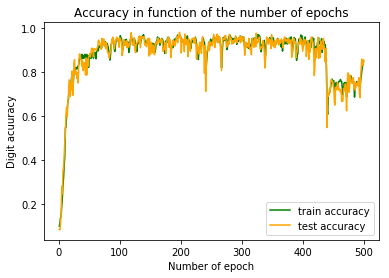

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 500, train_error:6.5%, test_error: 13.700000000000001%


In [527]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, optimizer_name = 'Adam')

[epoch 1] train loss: 2.298, test loss: 2.250
[epoch 2] train loss: 2.229, test loss: 2.171
[epoch 3] train loss: 2.253, test loss: 2.086
[epoch 4] train loss: 1.908, test loss: 1.897
[epoch 5] train loss: 1.772, test loss: 1.807
[epoch 6] train loss: 1.621, test loss: 1.700
[epoch 7] train loss: 1.519, test loss: 1.507
[epoch 8] train loss: 1.271, test loss: 1.428
[epoch 9] train loss: 1.180, test loss: 1.151
[epoch 10] train loss: 1.398, test loss: 1.254
[epoch 11] train loss: 1.104, test loss: 1.079
[epoch 12] train loss: 1.251, test loss: 1.077
[epoch 13] train loss: 1.157, test loss: 0.958
[epoch 14] train loss: 1.043, test loss: 0.889
[epoch 15] train loss: 0.979, test loss: 1.063
[epoch 16] train loss: 1.202, test loss: 0.975
[epoch 17] train loss: 0.933, test loss: 0.860
[epoch 18] train loss: 0.836, test loss: 0.925
[epoch 19] train loss: 0.978, test loss: 0.921
[epoch 20] train loss: 0.866, test loss: 0.720
[epoch 21] train loss: 0.961, test loss: 0.693
[epoch 22] train loss:

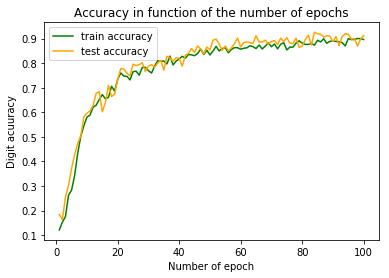

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:7.1%, test_error: 8.4%


In [525]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, optimizer_name = 'Adam')

[epoch 1] train loss: 2.315, test loss: 2.316
[epoch 2] train loss: 2.318, test loss: 2.308
[epoch 3] train loss: 2.303, test loss: 2.306
[epoch 4] train loss: 2.310, test loss: 2.307
[epoch 5] train loss: 2.308, test loss: 2.306
[epoch 6] train loss: 2.309, test loss: 2.306
[epoch 7] train loss: 2.310, test loss: 2.307
[epoch 8] train loss: 2.310, test loss: 2.307
[epoch 9] train loss: 2.310, test loss: 2.307
[epoch 10] train loss: 2.311, test loss: 2.307
[epoch 11] train loss: 2.311, test loss: 2.307
[epoch 12] train loss: 2.311, test loss: 2.307
[epoch 13] train loss: 2.311, test loss: 2.308
[epoch 14] train loss: 2.312, test loss: 2.308
[epoch 15] train loss: 2.312, test loss: 2.308
[epoch 16] train loss: 2.312, test loss: 2.308
[epoch 17] train loss: 2.312, test loss: 2.308
[epoch 18] train loss: 2.312, test loss: 2.308
[epoch 19] train loss: 2.312, test loss: 2.308
[epoch 20] train loss: 2.313, test loss: 2.308
[epoch 21] train loss: 2.313, test loss: 2.308
[epoch 22] train loss:

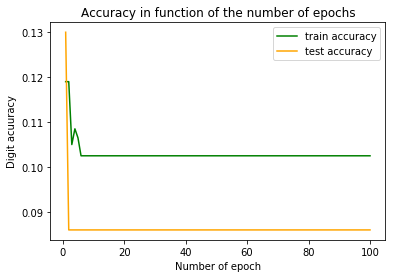

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:45.2%, test_error: 47.599999999999994%


In [546]:
train_test(BasicCNN_bis(dropout = 0), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, optimizer_name = 'Adam')

[epoch 1] train loss: 2.320, test loss: 2.313
[epoch 2] train loss: 2.313, test loss: 2.309
[epoch 3] train loss: 2.310, test loss: 2.307
[epoch 4] train loss: 2.313, test loss: 2.309
[epoch 5] train loss: 2.313, test loss: 2.309
[epoch 6] train loss: 2.313, test loss: 2.309
[epoch 7] train loss: 2.313, test loss: 2.309
[epoch 8] train loss: 2.313, test loss: 2.309
[epoch 9] train loss: 2.313, test loss: 2.309
[epoch 10] train loss: 2.313, test loss: 2.309
[epoch 11] train loss: 2.314, test loss: 2.309
[epoch 12] train loss: 2.314, test loss: 2.309
[epoch 13] train loss: 2.314, test loss: 2.309
[epoch 14] train loss: 2.314, test loss: 2.309
[epoch 15] train loss: 2.314, test loss: 2.309
[epoch 16] train loss: 2.314, test loss: 2.309
[epoch 17] train loss: 2.314, test loss: 2.309
[epoch 18] train loss: 2.314, test loss: 2.309
[epoch 19] train loss: 2.314, test loss: 2.310
[epoch 20] train loss: 2.314, test loss: 2.310
[epoch 21] train loss: 2.314, test loss: 2.310
[epoch 22] train loss:

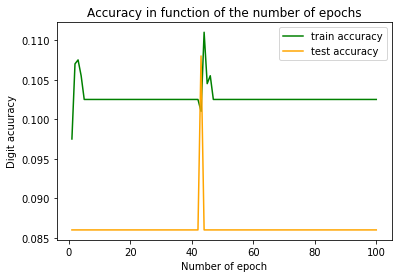

MODEL: BasicCNN_bis(dropout = 0.2), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:45.2%, test_error: 47.599999999999994%


In [547]:
train_test(BasicCNN_bis(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, optimizer_name = 'Adam')

[epoch 1] train loss: 2.297, test loss: 2.323
[epoch 2] train loss: 2.317, test loss: 2.306
[epoch 3] train loss: 2.308, test loss: 2.307
[epoch 4] train loss: 2.308, test loss: 2.306
[epoch 5] train loss: 2.310, test loss: 2.307
[epoch 6] train loss: 2.310, test loss: 2.307
[epoch 7] train loss: 2.311, test loss: 2.307
[epoch 8] train loss: 2.311, test loss: 2.307
[epoch 9] train loss: 2.311, test loss: 2.307
[epoch 10] train loss: 2.311, test loss: 2.308
[epoch 11] train loss: 2.311, test loss: 2.308
[epoch 12] train loss: 2.312, test loss: 2.308
[epoch 13] train loss: 2.312, test loss: 2.308
[epoch 14] train loss: 2.312, test loss: 2.308
[epoch 15] train loss: 2.312, test loss: 2.308
[epoch 16] train loss: 2.312, test loss: 2.308
[epoch 17] train loss: 2.312, test loss: 2.308
[epoch 18] train loss: 2.312, test loss: 2.308
[epoch 19] train loss: 2.313, test loss: 2.308
[epoch 20] train loss: 2.313, test loss: 2.308
[epoch 21] train loss: 2.313, test loss: 2.309
[epoch 22] train loss:

[epoch 174] train loss: 2.315, test loss: 2.310
[epoch 175] train loss: 2.315, test loss: 2.310
[epoch 176] train loss: 2.315, test loss: 2.310
[epoch 177] train loss: 2.315, test loss: 2.310
[epoch 178] train loss: 2.315, test loss: 2.310
[epoch 179] train loss: 2.315, test loss: 2.310
[epoch 180] train loss: 2.315, test loss: 2.310
[epoch 181] train loss: 2.315, test loss: 2.310
[epoch 182] train loss: 2.315, test loss: 2.310
[epoch 183] train loss: 2.315, test loss: 2.310
[epoch 184] train loss: 2.315, test loss: 2.310
[epoch 185] train loss: 2.315, test loss: 2.310
[epoch 186] train loss: 2.315, test loss: 2.310
[epoch 187] train loss: 2.315, test loss: 2.310
[epoch 188] train loss: 2.315, test loss: 2.310
[epoch 189] train loss: 2.315, test loss: 2.310
[epoch 190] train loss: 2.315, test loss: 2.310
[epoch 191] train loss: 2.315, test loss: 2.310
[epoch 192] train loss: 2.315, test loss: 2.310
[epoch 193] train loss: 2.315, test loss: 2.310
[epoch 194] train loss: 2.315, test loss

[epoch 345] train loss: 2.315, test loss: 2.310
[epoch 346] train loss: 2.315, test loss: 2.310
[epoch 347] train loss: 2.315, test loss: 2.310
[epoch 348] train loss: 2.315, test loss: 2.310
[epoch 349] train loss: 2.315, test loss: 2.310
[epoch 350] train loss: 2.315, test loss: 2.310
[epoch 351] train loss: 2.315, test loss: 2.310
[epoch 352] train loss: 2.315, test loss: 2.310
[epoch 353] train loss: 2.315, test loss: 2.310
[epoch 354] train loss: 2.315, test loss: 2.310
[epoch 355] train loss: 2.315, test loss: 2.310
[epoch 356] train loss: 2.315, test loss: 2.310
[epoch 357] train loss: 2.315, test loss: 2.310
[epoch 358] train loss: 2.315, test loss: 2.310
[epoch 359] train loss: 2.315, test loss: 2.310
[epoch 360] train loss: 2.315, test loss: 2.310
[epoch 361] train loss: 2.315, test loss: 2.310
[epoch 362] train loss: 2.315, test loss: 2.310
[epoch 363] train loss: 2.315, test loss: 2.310
[epoch 364] train loss: 2.315, test loss: 2.310
[epoch 365] train loss: 2.315, test loss

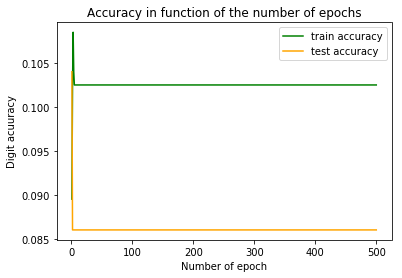

MODEL: BasicCNN_bis(dropout = 0.2), BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 500, train_error:45.2%, test_error: 47.599999999999994%


In [548]:
train_test(BasicCNN_bis(dropout = 0.2), 100, eta = 1e-1, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, optimizer_name = 'Adam')

#### Multi margin loss

[epoch 1] train loss: 0.341, test loss: 0.350
[epoch 2] train loss: 0.148, test loss: 0.152
[epoch 3] train loss: 0.255, test loss: 0.174
[epoch 4] train loss: 0.197, test loss: 0.080
[epoch 5] train loss: 0.114, test loss: 0.143
[epoch 6] train loss: 0.138, test loss: 0.066
[epoch 7] train loss: 0.066, test loss: 0.046
[epoch 8] train loss: 0.048, test loss: 0.037
[epoch 9] train loss: 0.050, test loss: 0.044
[epoch 10] train loss: 0.042, test loss: 0.035
[epoch 11] train loss: 0.032, test loss: 0.045
[epoch 12] train loss: 0.040, test loss: 0.027
[epoch 13] train loss: 0.053, test loss: 0.034
[epoch 14] train loss: 0.035, test loss: 0.033
[epoch 15] train loss: 0.021, test loss: 0.036
[epoch 16] train loss: 0.015, test loss: 0.022
[epoch 17] train loss: 0.028, test loss: 0.020
[epoch 18] train loss: 0.018, test loss: 0.019
[epoch 19] train loss: 0.010, test loss: 0.008
[epoch 20] train loss: 0.011, test loss: 0.023
[epoch 21] train loss: 0.008, test loss: 0.007
[epoch 22] train loss:

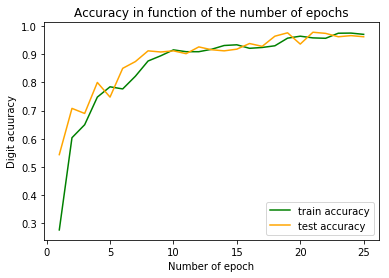

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 25, train_error:2.6%, test_error: 11.0%


In [549]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.883, test loss: 0.896
[epoch 2] train loss: 0.864, test loss: 0.875
[epoch 3] train loss: 0.709, test loss: 0.700
[epoch 4] train loss: 0.614, test loss: 0.592
[epoch 5] train loss: 0.474, test loss: 0.403
[epoch 6] train loss: 0.421, test loss: 0.349
[epoch 7] train loss: 0.410, test loss: 0.334
[epoch 8] train loss: 0.394, test loss: 0.304
[epoch 9] train loss: 0.399, test loss: 0.285
[epoch 10] train loss: 0.332, test loss: 0.259
[epoch 11] train loss: 0.337, test loss: 0.237
[epoch 12] train loss: 0.327, test loss: 0.250
[epoch 13] train loss: 0.302, test loss: 0.230
[epoch 14] train loss: 0.299, test loss: 0.171
[epoch 15] train loss: 0.269, test loss: 0.171
[epoch 16] train loss: 0.231, test loss: 0.155
[epoch 17] train loss: 0.212, test loss: 0.149
[epoch 18] train loss: 0.211, test loss: 0.154
[epoch 19] train loss: 0.204, test loss: 0.146
[epoch 20] train loss: 0.196, test loss: 0.149
[epoch 21] train loss: 0.208, test loss: 0.125
[epoch 22] train loss:

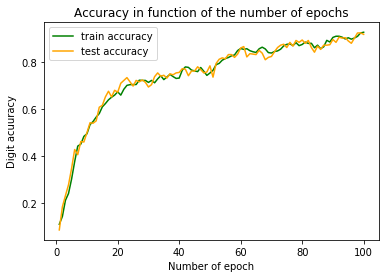

MODEL: BasicCNN_bis(dropout = 0), BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:5.6000000000000005%, test_error: 19.6%


In [551]:
train_test(BasicCNN_bis(), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.476, test loss: 0.551
[epoch 2] train loss: 0.424, test loss: 0.475
[epoch 3] train loss: 0.319, test loss: 0.478
[epoch 4] train loss: 0.429, test loss: 0.452
[epoch 5] train loss: 0.372, test loss: 0.323
[epoch 6] train loss: 0.236, test loss: 0.205
[epoch 7] train loss: 0.232, test loss: 0.216
[epoch 8] train loss: 0.175, test loss: 0.205
[epoch 9] train loss: 0.158, test loss: 0.145
[epoch 10] train loss: 0.152, test loss: 0.139
[epoch 11] train loss: 0.158, test loss: 0.133
[epoch 12] train loss: 0.129, test loss: 0.111
[epoch 13] train loss: 0.120, test loss: 0.114
[epoch 14] train loss: 0.163, test loss: 0.153
[epoch 15] train loss: 0.087, test loss: 0.094
[epoch 16] train loss: 0.080, test loss: 0.116
[epoch 17] train loss: 0.098, test loss: 0.109
[epoch 18] train loss: 0.101, test loss: 0.099
[epoch 19] train loss: 0.118, test loss: 0.112
[epoch 20] train loss: 0.104, test loss: 0.110
[epoch 21] train loss: 0.171, test loss: 0.098
[epoch 22] train loss:

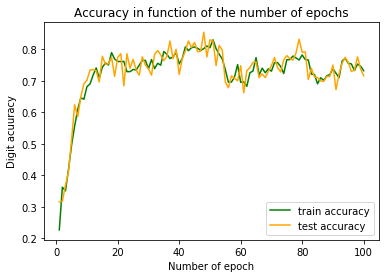

MODEL: BasicCNN_bis(dropout = 0.1), BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:18.099999999999998%, test_error: 21.6%


In [552]:
train_test(BasicCNN_bis(dropout = 0.1), 100, eta = 1e-1, criterion = nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x131736240>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 6

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 6

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([500, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
[epoch 9] train loss: 0.001, test loss: 0.002
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x131736240>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tenso

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 6

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([500, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
[epoch 18] train loss: 0.000, test loss: 0.001
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x137f01e58>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x138db0a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tens

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794ab0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4870>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x134794e10>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4a20>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4948>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1316b4750>
x  torch.Size([100, 6

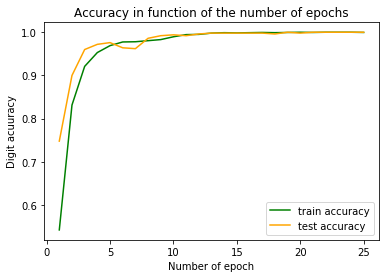

x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300af8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x1396e4708>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300750>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3003a8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3001f8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300318>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3005a0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b3003f0>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300168>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300af8>
x  torch.Size([100, 64, 5, 5])
x  <built-in method size of Tensor object at 0x12b300750>
x  torch.Size([100, 6

In [610]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 0.086, test loss: 0.059
[epoch 2] train loss: 0.072, test loss: 0.029
[epoch 3] train loss: 0.023, test loss: 0.012
[epoch 4] train loss: 0.017, test loss: 0.009
[epoch 5] train loss: 0.011, test loss: 0.009
[epoch 6] train loss: 0.004, test loss: 0.007
[epoch 7] train loss: 0.001, test loss: 0.004
[epoch 8] train loss: 0.002, test loss: 0.005
[epoch 9] train loss: 0.002, test loss: 0.001
[epoch 10] train loss: 0.001, test loss: 0.002
[epoch 11] train loss: 0.001, test loss: 0.001
[epoch 12] train loss: 0.000, test loss: 0.001
[epoch 13] train loss: 0.000, test loss: 0.001
[epoch 14] train loss: 0.000, test loss: 0.000
[epoch 15] train loss: 0.000, test loss: 0.000
[epoch 16] train loss: 0.000, test loss: 0.000
[epoch 17] train loss: 0.000, test loss: 0.000
[epoch 18] train loss: 0.000, test loss: 0.000
[epoch 19] train loss: 0.000, test loss: 0.000
[epoch 20] train loss: 0.000, test loss: 0.000
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

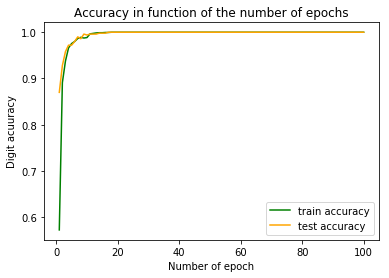

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:0.0%, test_error: 3.2%


In [554]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.176, test loss: 0.131
[epoch 2] train loss: 0.133, test loss: 0.057
[epoch 3] train loss: 0.059, test loss: 0.031
[epoch 4] train loss: 0.039, test loss: 0.027
[epoch 5] train loss: 0.033, test loss: 0.018
[epoch 6] train loss: 0.023, test loss: 0.021
[epoch 7] train loss: 0.020, test loss: 0.019
[epoch 8] train loss: 0.028, test loss: 0.018
[epoch 9] train loss: 0.016, test loss: 0.020
[epoch 10] train loss: 0.023, test loss: 0.015
[epoch 11] train loss: 0.018, test loss: 0.014
[epoch 12] train loss: 0.015, test loss: 0.014
[epoch 13] train loss: 0.009, test loss: 0.011
[epoch 14] train loss: 0.008, test loss: 0.007
[epoch 15] train loss: 0.014, test loss: 0.007
[epoch 16] train loss: 0.005, test loss: 0.004
[epoch 17] train loss: 0.006, test loss: 0.005
[epoch 18] train loss: 0.007, test loss: 0.004
[epoch 19] train loss: 0.006, test loss: 0.004
[epoch 20] train loss: 0.007, test loss: 0.004
[epoch 21] train loss: 0.004, test loss: 0.003
[epoch 22] train loss:

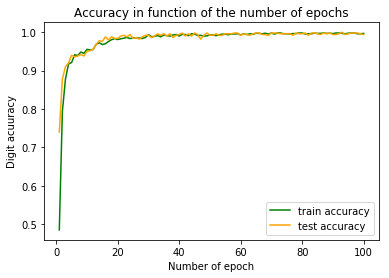

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 100, train_error:0.4%, test_error: 4.1000000000000005%


In [555]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 0.163, test loss: 0.090
[epoch 2] train loss: 0.089, test loss: 0.067
[epoch 3] train loss: 0.069, test loss: 0.033
[epoch 4] train loss: 0.033, test loss: 0.023
[epoch 5] train loss: 0.030, test loss: 0.017
[epoch 6] train loss: 0.043, test loss: 0.014
[epoch 7] train loss: 0.020, test loss: 0.015
[epoch 8] train loss: 0.010, test loss: 0.013
[epoch 9] train loss: 0.019, test loss: 0.015
[epoch 10] train loss: 0.012, test loss: 0.015
[epoch 11] train loss: 0.012, test loss: 0.012
[epoch 12] train loss: 0.008, test loss: 0.011
[epoch 13] train loss: 0.011, test loss: 0.009
[epoch 14] train loss: 0.007, test loss: 0.008
[epoch 15] train loss: 0.004, test loss: 0.008
[epoch 16] train loss: 0.017, test loss: 0.004
[epoch 17] train loss: 0.006, test loss: 0.007
[epoch 18] train loss: 0.015, test loss: 0.006
[epoch 19] train loss: 0.008, test loss: 0.005
[epoch 20] train loss: 0.004, test loss: 0.003
[epoch 21] train loss: 0.006, test loss: 0.004
[epoch 22] train loss:

[epoch 174] train loss: 0.000, test loss: 0.000
[epoch 175] train loss: 0.003, test loss: 0.001
[epoch 176] train loss: 0.002, test loss: 0.000
[epoch 177] train loss: 0.001, test loss: 0.001
[epoch 178] train loss: 0.001, test loss: 0.000
[epoch 179] train loss: 0.000, test loss: 0.001
[epoch 180] train loss: 0.000, test loss: 0.000
[epoch 181] train loss: 0.000, test loss: 0.001
[epoch 182] train loss: 0.000, test loss: 0.000
[epoch 183] train loss: 0.001, test loss: 0.000
[epoch 184] train loss: 0.000, test loss: 0.000
[epoch 185] train loss: 0.000, test loss: 0.002
[epoch 186] train loss: 0.001, test loss: 0.001
[epoch 187] train loss: 0.000, test loss: 0.001
[epoch 188] train loss: 0.000, test loss: 0.001
[epoch 189] train loss: 0.001, test loss: 0.000
[epoch 190] train loss: 0.003, test loss: 0.001
[epoch 191] train loss: 0.003, test loss: 0.000
[epoch 192] train loss: 0.000, test loss: 0.000
[epoch 193] train loss: 0.001, test loss: 0.000
[epoch 194] train loss: 0.000, test loss

[epoch 345] train loss: 0.000, test loss: 0.000
[epoch 346] train loss: 0.000, test loss: 0.000
[epoch 347] train loss: 0.001, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.000
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.000, test loss: 0.000
[epoch 353] train loss: 0.000, test loss: 0.000
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.002, test loss: 0.000
[epoch 356] train loss: 0.001, test loss: 0.000
[epoch 357] train loss: 0.002, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.001
[epoch 359] train loss: 0.000, test loss: 0.000
[epoch 360] train loss: 0.000, test loss: 0.000
[epoch 361] train loss: 0.000, test loss: 0.000
[epoch 362] train loss: 0.000, test loss: 0.000
[epoch 363] train loss: 0.000, test loss: 0.001
[epoch 364] train loss: 0.000, test loss: 0.000
[epoch 365] train loss: 0.000, test loss

[epoch 516] train loss: 0.000, test loss: 0.000
[epoch 517] train loss: 0.000, test loss: 0.000
[epoch 518] train loss: 0.000, test loss: 0.001
[epoch 519] train loss: 0.003, test loss: 0.001
[epoch 520] train loss: 0.000, test loss: 0.000
[epoch 521] train loss: 0.000, test loss: 0.000
[epoch 522] train loss: 0.000, test loss: 0.000
[epoch 523] train loss: 0.000, test loss: 0.000
[epoch 524] train loss: 0.000, test loss: 0.000
[epoch 525] train loss: 0.000, test loss: 0.000
[epoch 526] train loss: 0.000, test loss: 0.000
[epoch 527] train loss: 0.000, test loss: 0.000
[epoch 528] train loss: 0.001, test loss: 0.000
[epoch 529] train loss: 0.000, test loss: 0.000
[epoch 530] train loss: 0.000, test loss: 0.000
[epoch 531] train loss: 0.000, test loss: 0.000
[epoch 532] train loss: 0.000, test loss: 0.000
[epoch 533] train loss: 0.000, test loss: 0.000
[epoch 534] train loss: 0.000, test loss: 0.000
[epoch 535] train loss: 0.000, test loss: 0.000
[epoch 536] train loss: 0.000, test loss

[epoch 687] train loss: 0.000, test loss: 0.000
[epoch 688] train loss: 0.000, test loss: 0.000
[epoch 689] train loss: 0.000, test loss: 0.000
[epoch 690] train loss: 0.000, test loss: 0.001
[epoch 691] train loss: 0.000, test loss: 0.000
[epoch 692] train loss: 0.000, test loss: 0.000
[epoch 693] train loss: 0.000, test loss: 0.000
[epoch 694] train loss: 0.000, test loss: 0.000
[epoch 695] train loss: 0.000, test loss: 0.000
[epoch 696] train loss: 0.000, test loss: 0.000
[epoch 697] train loss: 0.000, test loss: 0.000
[epoch 698] train loss: 0.000, test loss: 0.000
[epoch 699] train loss: 0.000, test loss: 0.000
[epoch 700] train loss: 0.000, test loss: 0.000
[epoch 701] train loss: 0.000, test loss: 0.000
[epoch 702] train loss: 0.000, test loss: 0.000
[epoch 703] train loss: 0.000, test loss: 0.000
[epoch 704] train loss: 0.000, test loss: 0.000
[epoch 705] train loss: 0.001, test loss: 0.000
[epoch 706] train loss: 0.000, test loss: 0.000
[epoch 707] train loss: 0.000, test loss

[epoch 858] train loss: 0.000, test loss: 0.000
[epoch 859] train loss: 0.000, test loss: 0.000
[epoch 860] train loss: 0.000, test loss: 0.000
[epoch 861] train loss: 0.000, test loss: 0.000
[epoch 862] train loss: 0.000, test loss: 0.000
[epoch 863] train loss: 0.000, test loss: 0.000
[epoch 864] train loss: 0.000, test loss: 0.000
[epoch 865] train loss: 0.000, test loss: 0.000
[epoch 866] train loss: 0.000, test loss: 0.000
[epoch 867] train loss: 0.000, test loss: 0.000
[epoch 868] train loss: 0.000, test loss: 0.000
[epoch 869] train loss: 0.000, test loss: 0.000
[epoch 870] train loss: 0.000, test loss: 0.000
[epoch 871] train loss: 0.000, test loss: 0.000
[epoch 872] train loss: 0.000, test loss: 0.000
[epoch 873] train loss: 0.000, test loss: 0.000
[epoch 874] train loss: 0.000, test loss: 0.000
[epoch 875] train loss: 0.000, test loss: 0.000
[epoch 876] train loss: 0.000, test loss: 0.000
[epoch 877] train loss: 0.000, test loss: 0.000
[epoch 878] train loss: 0.000, test loss

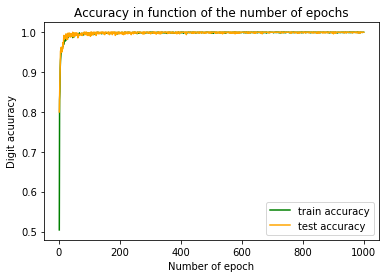

MODEL: BasicCNN with batch normalization, dropout = 0.2, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 1000, train_error:0.1%, test_error: 1.6%


In [556]:
train_test(BasicCNN_bn(dropout = 0.2), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 1000, momentum = 0.9)

[epoch 1] train loss: 0.160, test loss: 0.148
[epoch 2] train loss: 0.061, test loss: 0.028
[epoch 3] train loss: 0.026, test loss: 0.014
[epoch 4] train loss: 0.029, test loss: 0.011
[epoch 5] train loss: 0.012, test loss: 0.008
[epoch 6] train loss: 0.012, test loss: 0.013
[epoch 7] train loss: 0.005, test loss: 0.016
[epoch 8] train loss: 0.006, test loss: 0.007
[epoch 9] train loss: 0.003, test loss: 0.006
[epoch 10] train loss: 0.001, test loss: 0.002
[epoch 11] train loss: 0.000, test loss: 0.002
[epoch 12] train loss: 0.000, test loss: 0.001
[epoch 13] train loss: 0.000, test loss: 0.001
[epoch 14] train loss: 0.000, test loss: 0.001
[epoch 15] train loss: 0.000, test loss: 0.001
[epoch 16] train loss: 0.000, test loss: 0.001
[epoch 17] train loss: 0.000, test loss: 0.001
[epoch 18] train loss: 0.000, test loss: 0.000
[epoch 19] train loss: 0.000, test loss: 0.000
[epoch 20] train loss: 0.000, test loss: 0.000
[epoch 21] train loss: 0.000, test loss: 0.000
[epoch 22] train loss:

[epoch 174] train loss: 0.000, test loss: 0.000
[epoch 175] train loss: 0.000, test loss: 0.000
[epoch 176] train loss: 0.000, test loss: 0.000
[epoch 177] train loss: 0.000, test loss: 0.000
[epoch 178] train loss: 0.000, test loss: 0.000
[epoch 179] train loss: 0.000, test loss: 0.000
[epoch 180] train loss: 0.000, test loss: 0.000
[epoch 181] train loss: 0.000, test loss: 0.000
[epoch 182] train loss: 0.000, test loss: 0.000
[epoch 183] train loss: 0.000, test loss: 0.000
[epoch 184] train loss: 0.000, test loss: 0.000
[epoch 185] train loss: 0.000, test loss: 0.000
[epoch 186] train loss: 0.000, test loss: 0.000
[epoch 187] train loss: 0.000, test loss: 0.000
[epoch 188] train loss: 0.000, test loss: 0.000
[epoch 189] train loss: 0.000, test loss: 0.000
[epoch 190] train loss: 0.000, test loss: 0.000
[epoch 191] train loss: 0.000, test loss: 0.000
[epoch 192] train loss: 0.000, test loss: 0.000
[epoch 193] train loss: 0.000, test loss: 0.000
[epoch 194] train loss: 0.000, test loss

[epoch 345] train loss: 0.000, test loss: 0.000
[epoch 346] train loss: 0.000, test loss: 0.000
[epoch 347] train loss: 0.000, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.000
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.000, test loss: 0.000
[epoch 353] train loss: 0.000, test loss: 0.000
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.000, test loss: 0.000
[epoch 356] train loss: 0.000, test loss: 0.000
[epoch 357] train loss: 0.000, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.000
[epoch 359] train loss: 0.000, test loss: 0.000
[epoch 360] train loss: 0.000, test loss: 0.000
[epoch 361] train loss: 0.000, test loss: 0.000
[epoch 362] train loss: 0.000, test loss: 0.000
[epoch 363] train loss: 0.000, test loss: 0.000
[epoch 364] train loss: 0.000, test loss: 0.000
[epoch 365] train loss: 0.000, test loss

[epoch 516] train loss: 0.000, test loss: 0.000
[epoch 517] train loss: 0.000, test loss: 0.000
[epoch 518] train loss: 0.000, test loss: 0.000
[epoch 519] train loss: 0.000, test loss: 0.000
[epoch 520] train loss: 0.000, test loss: 0.000
[epoch 521] train loss: 0.000, test loss: 0.000
[epoch 522] train loss: 0.000, test loss: 0.000
[epoch 523] train loss: 0.000, test loss: 0.000
[epoch 524] train loss: 0.000, test loss: 0.000
[epoch 525] train loss: 0.000, test loss: 0.000
[epoch 526] train loss: 0.000, test loss: 0.000
[epoch 527] train loss: 0.000, test loss: 0.000
[epoch 528] train loss: 0.000, test loss: 0.000
[epoch 529] train loss: 0.000, test loss: 0.000
[epoch 530] train loss: 0.000, test loss: 0.000
[epoch 531] train loss: 0.000, test loss: 0.000
[epoch 532] train loss: 0.000, test loss: 0.000
[epoch 533] train loss: 0.000, test loss: 0.000
[epoch 534] train loss: 0.000, test loss: 0.000
[epoch 535] train loss: 0.000, test loss: 0.000
[epoch 536] train loss: 0.000, test loss

[epoch 687] train loss: 0.000, test loss: 0.000
[epoch 688] train loss: 0.000, test loss: 0.000
[epoch 689] train loss: 0.000, test loss: 0.000
[epoch 690] train loss: 0.000, test loss: 0.000
[epoch 691] train loss: 0.000, test loss: 0.000
[epoch 692] train loss: 0.000, test loss: 0.000
[epoch 693] train loss: 0.000, test loss: 0.000
[epoch 694] train loss: 0.000, test loss: 0.000
[epoch 695] train loss: 0.000, test loss: 0.000
[epoch 696] train loss: 0.000, test loss: 0.000
[epoch 697] train loss: 0.000, test loss: 0.000
[epoch 698] train loss: 0.000, test loss: 0.000
[epoch 699] train loss: 0.000, test loss: 0.000
[epoch 700] train loss: 0.000, test loss: 0.000
[epoch 701] train loss: 0.000, test loss: 0.000
[epoch 702] train loss: 0.000, test loss: 0.000
[epoch 703] train loss: 0.000, test loss: 0.000
[epoch 704] train loss: 0.000, test loss: 0.000
[epoch 705] train loss: 0.000, test loss: 0.000
[epoch 706] train loss: 0.000, test loss: 0.000
[epoch 707] train loss: 0.000, test loss

[epoch 858] train loss: 0.000, test loss: 0.000
[epoch 859] train loss: 0.000, test loss: 0.000
[epoch 860] train loss: 0.000, test loss: 0.000
[epoch 861] train loss: 0.000, test loss: 0.000
[epoch 862] train loss: 0.000, test loss: 0.000
[epoch 863] train loss: 0.000, test loss: 0.000
[epoch 864] train loss: 0.000, test loss: 0.000
[epoch 865] train loss: 0.000, test loss: 0.000
[epoch 866] train loss: 0.000, test loss: 0.000
[epoch 867] train loss: 0.000, test loss: 0.000
[epoch 868] train loss: 0.000, test loss: 0.000
[epoch 869] train loss: 0.000, test loss: 0.000
[epoch 870] train loss: 0.000, test loss: 0.000
[epoch 871] train loss: 0.000, test loss: 0.000
[epoch 872] train loss: 0.000, test loss: 0.000
[epoch 873] train loss: 0.000, test loss: 0.000
[epoch 874] train loss: 0.000, test loss: 0.000
[epoch 875] train loss: 0.000, test loss: 0.000
[epoch 876] train loss: 0.000, test loss: 0.000
[epoch 877] train loss: 0.000, test loss: 0.000
[epoch 878] train loss: 0.000, test loss

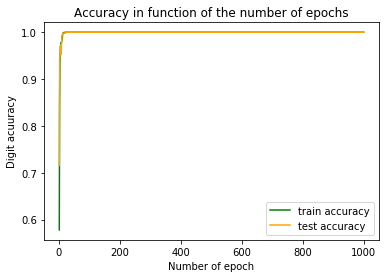

MODEL: BasicCNN with batch normalization, dropout = 0, BATCH_SIZE: 100, CRITERION: MultiMarginLoss(), EPOCHS: 1000, train_error:0.0%, test_error: 2.7%


In [557]:
train_test(BasicCNN_bn(dropout = 0), 100, eta = 1e-1, criterion =nn.MultiMarginLoss(), nb_epochs = 1000, momentum = 0.9)

### Unet optimization

[epoch 1] train loss: 1.895, test loss: 1.797
[epoch 2] train loss: 0.629, test loss: 0.538
[epoch 3] train loss: 0.382, test loss: 0.251
[epoch 4] train loss: 0.218, test loss: 0.164
[epoch 5] train loss: 0.204, test loss: 0.120
[epoch 6] train loss: 0.123, test loss: 0.089
[epoch 7] train loss: 0.087, test loss: 0.083
[epoch 8] train loss: 0.094, test loss: 0.060
[epoch 9] train loss: 0.091, test loss: 0.058
[epoch 10] train loss: 0.096, test loss: 0.050
[epoch 11] train loss: 0.042, test loss: 0.042
[epoch 12] train loss: 0.026, test loss: 0.036
[epoch 13] train loss: 0.028, test loss: 0.027
[epoch 14] train loss: 0.028, test loss: 0.023
[epoch 15] train loss: 0.039, test loss: 0.017
[epoch 16] train loss: 0.030, test loss: 0.010
[epoch 17] train loss: 0.011, test loss: 0.013
[epoch 18] train loss: 0.005, test loss: 0.009
[epoch 19] train loss: 0.015, test loss: 0.012
[epoch 20] train loss: 0.019, test loss: 0.015
[epoch 21] train loss: 0.011, test loss: 0.012
[epoch 22] train loss:

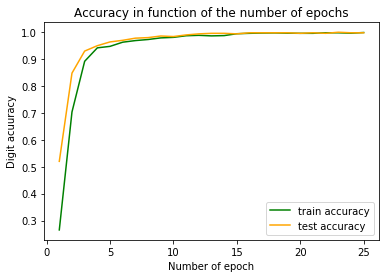

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:0.1%, test_error: 2.1%


In [604]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 1.845, test loss: 1.757
[epoch 2] train loss: 0.856, test loss: 0.663
[epoch 3] train loss: 0.383, test loss: 0.279
[epoch 4] train loss: 0.302, test loss: 0.183
[epoch 5] train loss: 0.294, test loss: 0.146
[epoch 6] train loss: 0.159, test loss: 0.117
[epoch 7] train loss: 0.117, test loss: 0.075
[epoch 8] train loss: 0.111, test loss: 0.062
[epoch 9] train loss: 0.081, test loss: 0.047
[epoch 10] train loss: 0.054, test loss: 0.024
[epoch 11] train loss: 0.057, test loss: 0.033
[epoch 12] train loss: 0.030, test loss: 0.022
[epoch 13] train loss: 0.033, test loss: 0.018
[epoch 14] train loss: 0.046, test loss: 0.023
[epoch 15] train loss: 0.043, test loss: 0.021
[epoch 16] train loss: 0.013, test loss: 0.023
[epoch 17] train loss: 0.033, test loss: 0.015
[epoch 18] train loss: 0.016, test loss: 0.007
[epoch 19] train loss: 0.012, test loss: 0.010
[epoch 20] train loss: 0.009, test loss: 0.011
[epoch 21] train loss: 0.014, test loss: 0.005
[epoch 22] train loss:

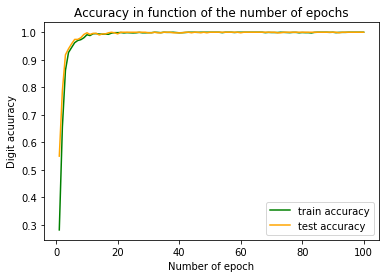

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.0%, test_error: 2.0%


In [605]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 1.804, test loss: 1.719
[epoch 2] train loss: 0.634, test loss: 0.602
[epoch 3] train loss: 0.302, test loss: 0.280
[epoch 4] train loss: 0.218, test loss: 0.192
[epoch 5] train loss: 0.216, test loss: 0.164
[epoch 6] train loss: 0.176, test loss: 0.138
[epoch 7] train loss: 0.103, test loss: 0.104
[epoch 8] train loss: 0.098, test loss: 0.091
[epoch 9] train loss: 0.074, test loss: 0.058
[epoch 10] train loss: 0.064, test loss: 0.054
[epoch 11] train loss: 0.047, test loss: 0.039
[epoch 12] train loss: 0.104, test loss: 0.019
[epoch 13] train loss: 0.042, test loss: 0.018
[epoch 14] train loss: 0.059, test loss: 0.017
[epoch 15] train loss: 0.018, test loss: 0.018
[epoch 16] train loss: 0.010, test loss: 0.017
[epoch 17] train loss: 0.033, test loss: 0.016
[epoch 18] train loss: 0.023, test loss: 0.015
[epoch 19] train loss: 0.013, test loss: 0.012
[epoch 20] train loss: 0.010, test loss: 0.016
[epoch 21] train loss: 0.030, test loss: 0.005
[epoch 22] train loss:

[epoch 174] train loss: 0.000, test loss: 0.000
[epoch 175] train loss: 0.000, test loss: 0.001
[epoch 176] train loss: 0.002, test loss: 0.000
[epoch 177] train loss: 0.004, test loss: 0.001
[epoch 178] train loss: 0.000, test loss: 0.003
[epoch 179] train loss: 0.000, test loss: 0.001
[epoch 180] train loss: 0.007, test loss: 0.000
[epoch 181] train loss: 0.000, test loss: 0.001
[epoch 182] train loss: 0.000, test loss: 0.001
[epoch 183] train loss: 0.001, test loss: 0.003
[epoch 184] train loss: 0.000, test loss: 0.001
[epoch 185] train loss: 0.001, test loss: 0.000
[epoch 186] train loss: 0.001, test loss: 0.000
[epoch 187] train loss: 0.000, test loss: 0.001
[epoch 188] train loss: 0.000, test loss: 0.001
[epoch 189] train loss: 0.001, test loss: 0.000
[epoch 190] train loss: 0.001, test loss: 0.001
[epoch 191] train loss: 0.000, test loss: 0.000
[epoch 192] train loss: 0.000, test loss: 0.001
[epoch 193] train loss: 0.000, test loss: 0.001
[epoch 194] train loss: 0.000, test loss

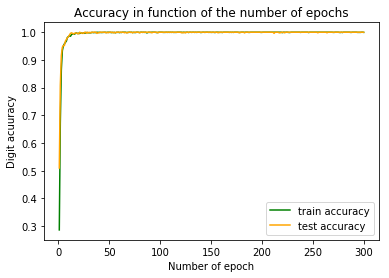

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 300, train_error:0.0%, test_error: 2.1999999999999997%


In [606]:
train_test(UNet(), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 300, momentum = 0.9)

[epoch 1] train loss: 2.005, test loss: 1.939
[epoch 2] train loss: 0.907, test loss: 0.753
[epoch 3] train loss: 0.373, test loss: 0.274
[epoch 4] train loss: 0.265, test loss: 0.168
[epoch 5] train loss: 0.205, test loss: 0.137
[epoch 6] train loss: 0.124, test loss: 0.102
[epoch 7] train loss: 0.153, test loss: 0.113
[epoch 8] train loss: 0.082, test loss: 0.084
[epoch 9] train loss: 0.059, test loss: 0.104
[epoch 10] train loss: 0.062, test loss: 0.058
[epoch 11] train loss: 0.031, test loss: 0.040
[epoch 12] train loss: 0.019, test loss: 0.018
[epoch 13] train loss: 0.041, test loss: 0.024
[epoch 14] train loss: 0.023, test loss: 0.015
[epoch 15] train loss: 0.024, test loss: 0.011
[epoch 16] train loss: 0.018, test loss: 0.009
[epoch 17] train loss: 0.013, test loss: 0.009
[epoch 18] train loss: 0.019, test loss: 0.010
[epoch 19] train loss: 0.013, test loss: 0.011
[epoch 20] train loss: 0.010, test loss: 0.008
[epoch 21] train loss: 0.021, test loss: 0.007
[epoch 22] train loss:

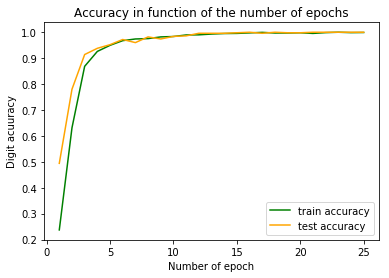

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 25, train_error:0.1%, test_error: 1.5%


In [623]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 25, momentum = 0.9)

[epoch 1] train loss: 1.965, test loss: 1.956
[epoch 2] train loss: 1.028, test loss: 0.942
[epoch 3] train loss: 0.372, test loss: 0.279
[epoch 4] train loss: 0.246, test loss: 0.177
[epoch 5] train loss: 0.206, test loss: 0.128
[epoch 6] train loss: 0.204, test loss: 0.110
[epoch 7] train loss: 0.121, test loss: 0.085
[epoch 8] train loss: 0.112, test loss: 0.075
[epoch 9] train loss: 0.043, test loss: 0.040
[epoch 10] train loss: 0.042, test loss: 0.036
[epoch 11] train loss: 0.060, test loss: 0.038
[epoch 12] train loss: 0.075, test loss: 0.026
[epoch 13] train loss: 0.014, test loss: 0.021
[epoch 14] train loss: 0.016, test loss: 0.019
[epoch 15] train loss: 0.017, test loss: 0.012
[epoch 16] train loss: 0.009, test loss: 0.013
[epoch 17] train loss: 0.014, test loss: 0.012
[epoch 18] train loss: 0.023, test loss: 0.008
[epoch 19] train loss: 0.014, test loss: 0.007
[epoch 20] train loss: 0.010, test loss: 0.010
[epoch 21] train loss: 0.009, test loss: 0.007
[epoch 22] train loss:

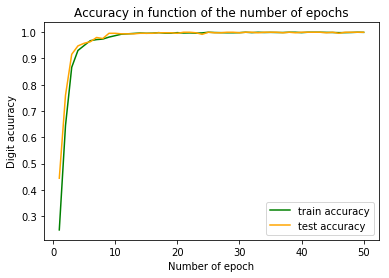

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 50, train_error:0.0%, test_error: 2.4%


In [619]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 50, momentum = 0.9)

[epoch 1] train loss: 2.028, test loss: 1.980
[epoch 2] train loss: 1.183, test loss: 1.001
[epoch 3] train loss: 0.442, test loss: 0.314
[epoch 4] train loss: 0.247, test loss: 0.182
[epoch 5] train loss: 0.195, test loss: 0.141
[epoch 6] train loss: 0.205, test loss: 0.128
[epoch 7] train loss: 0.145, test loss: 0.115
[epoch 8] train loss: 0.095, test loss: 0.083
[epoch 9] train loss: 0.040, test loss: 0.048
[epoch 10] train loss: 0.065, test loss: 0.036
[epoch 11] train loss: 0.020, test loss: 0.027
[epoch 12] train loss: 0.025, test loss: 0.012
[epoch 13] train loss: 0.022, test loss: 0.010
[epoch 14] train loss: 0.025, test loss: 0.020
[epoch 15] train loss: 0.011, test loss: 0.012
[epoch 16] train loss: 0.011, test loss: 0.013
[epoch 17] train loss: 0.031, test loss: 0.007
[epoch 18] train loss: 0.015, test loss: 0.009
[epoch 19] train loss: 0.009, test loss: 0.012
[epoch 20] train loss: 0.024, test loss: 0.008
[epoch 21] train loss: 0.007, test loss: 0.005
[epoch 22] train loss:

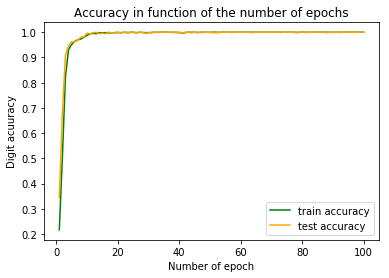

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.0%, test_error: 2.4%


In [620]:
train_test(UNet(dropout = 0.2), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.266, test loss: 2.267
[epoch 2] train loss: 2.035, test loss: 1.995
[epoch 3] train loss: 1.504, test loss: 1.429
[epoch 4] train loss: 0.868, test loss: 0.715
[epoch 5] train loss: 0.560, test loss: 0.389
[epoch 6] train loss: 0.371, test loss: 0.219
[epoch 7] train loss: 0.322, test loss: 0.180
[epoch 8] train loss: 0.285, test loss: 0.192
[epoch 9] train loss: 0.235, test loss: 0.152
[epoch 10] train loss: 0.152, test loss: 0.108
[epoch 11] train loss: 0.156, test loss: 0.104
[epoch 12] train loss: 0.184, test loss: 0.069
[epoch 13] train loss: 0.137, test loss: 0.073
[epoch 14] train loss: 0.073, test loss: 0.055
[epoch 15] train loss: 0.072, test loss: 0.053
[epoch 16] train loss: 0.061, test loss: 0.051
[epoch 17] train loss: 0.111, test loss: 0.056
[epoch 18] train loss: 0.080, test loss: 0.040
[epoch 19] train loss: 0.130, test loss: 0.037
[epoch 20] train loss: 0.062, test loss: 0.047
[epoch 21] train loss: 0.039, test loss: 0.049
[epoch 22] train loss:

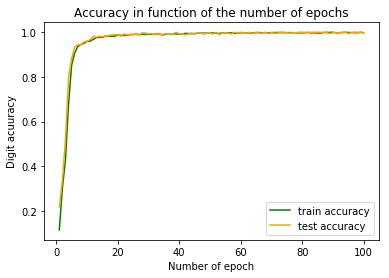

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 100, train_error:0.1%, test_error: 1.5%


In [621]:
train_test(UNet(dropout = 0.4), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 100, momentum = 0.9)

[epoch 1] train loss: 2.262, test loss: 2.248
[epoch 2] train loss: 1.944, test loss: 1.920
[epoch 3] train loss: 1.261, test loss: 1.166
[epoch 4] train loss: 0.519, test loss: 0.453
[epoch 5] train loss: 0.363, test loss: 0.273
[epoch 6] train loss: 0.312, test loss: 0.204
[epoch 7] train loss: 0.289, test loss: 0.183
[epoch 8] train loss: 0.277, test loss: 0.189
[epoch 9] train loss: 0.273, test loss: 0.178
[epoch 10] train loss: 0.153, test loss: 0.161
[epoch 11] train loss: 0.162, test loss: 0.088
[epoch 12] train loss: 0.134, test loss: 0.091
[epoch 13] train loss: 0.112, test loss: 0.080
[epoch 14] train loss: 0.141, test loss: 0.053
[epoch 15] train loss: 0.090, test loss: 0.062
[epoch 16] train loss: 0.112, test loss: 0.059
[epoch 17] train loss: 0.072, test loss: 0.051
[epoch 18] train loss: 0.052, test loss: 0.042
[epoch 19] train loss: 0.089, test loss: 0.030
[epoch 20] train loss: 0.050, test loss: 0.047
[epoch 21] train loss: 0.123, test loss: 0.035
[epoch 22] train loss:

[epoch 174] train loss: 0.001, test loss: 0.008
[epoch 175] train loss: 0.007, test loss: 0.001
[epoch 176] train loss: 0.002, test loss: 0.003
[epoch 177] train loss: 0.004, test loss: 0.001
[epoch 178] train loss: 0.011, test loss: 0.001
[epoch 179] train loss: 0.008, test loss: 0.001
[epoch 180] train loss: 0.035, test loss: 0.002
[epoch 181] train loss: 0.002, test loss: 0.006
[epoch 182] train loss: 0.001, test loss: 0.005
[epoch 183] train loss: 0.002, test loss: 0.003
[epoch 184] train loss: 0.001, test loss: 0.011
[epoch 185] train loss: 0.000, test loss: 0.001
[epoch 186] train loss: 0.000, test loss: 0.002
[epoch 187] train loss: 0.001, test loss: 0.002
[epoch 188] train loss: 0.000, test loss: 0.000
[epoch 189] train loss: 0.000, test loss: 0.001
[epoch 190] train loss: 0.008, test loss: 0.003
[epoch 191] train loss: 0.000, test loss: 0.001
[epoch 192] train loss: 0.001, test loss: 0.001
[epoch 193] train loss: 0.015, test loss: 0.003
[epoch 194] train loss: 0.002, test loss

[epoch 345] train loss: 0.000, test loss: 0.001
[epoch 346] train loss: 0.001, test loss: 0.001
[epoch 347] train loss: 0.000, test loss: 0.000
[epoch 348] train loss: 0.000, test loss: 0.000
[epoch 349] train loss: 0.000, test loss: 0.000
[epoch 350] train loss: 0.000, test loss: 0.000
[epoch 351] train loss: 0.000, test loss: 0.000
[epoch 352] train loss: 0.005, test loss: 0.000
[epoch 353] train loss: 0.000, test loss: 0.001
[epoch 354] train loss: 0.000, test loss: 0.000
[epoch 355] train loss: 0.003, test loss: 0.000
[epoch 356] train loss: 0.029, test loss: 0.000
[epoch 357] train loss: 0.000, test loss: 0.000
[epoch 358] train loss: 0.000, test loss: 0.001
[epoch 359] train loss: 0.000, test loss: 0.003
[epoch 360] train loss: 0.002, test loss: 0.000
[epoch 361] train loss: 0.000, test loss: 0.002
[epoch 362] train loss: 0.001, test loss: 0.000
[epoch 363] train loss: 0.004, test loss: 0.001
[epoch 364] train loss: 0.000, test loss: 0.003
[epoch 365] train loss: 0.001, test loss

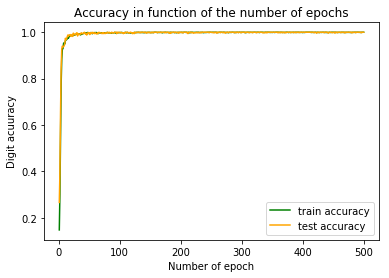

MODEL: UNet, BATCH_SIZE: 100, CRITERION: CrossEntropyLoss(), EPOCHS: 500, train_error:0.0%, test_error: 2.1%


In [622]:
train_test(UNet(dropout = 0.4), 100, eta = 1e-2, criterion =nn.CrossEntropyLoss(), nb_epochs = 500, momentum = 0.9)